# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


In [4]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)



In [5]:
# print(df_full.info())

In [6]:
# print(df_train.info())

In [7]:
# print(df_test.info())

Имеем один полный датафрейм и два, составляющих его части. Наличествует множество пропусков. Колонка [date], хоть и содержит дату, имеет тип танных object. Исправим это:

In [8]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_full['date'] = pd.to_datetime(df_full['date'])

#### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [9]:

df_train['rougher.calculation.recovery'] = 100*df_train['rougher.output.concentrate_au']*(df_train['rougher.input.feed_au']-
                                          df_train['rougher.output.tail_au'])/(df_train['rougher.input.feed_au']*(df_train['rougher.output.concentrate_au']-df_train['rougher.output.tail_au']))
  

In [10]:
display(df_train[['rougher.calculation.recovery', 'rougher.output.recovery']].isna().sum())
print('MAE между расчётным значением и значением признака: ', abs(df_train['rougher.calculation.recovery'] - df_train['rougher.output.recovery']).sum()/len(df_train['rougher.calculation.recovery']))

rougher.calculation.recovery    2283
rougher.output.recovery         2573
dtype: int64

MAE между расчётным значением и значением признака:  9.567251432893188e-15


Эффективность обогащения рассчитана правильно. Средняя абсолютная ошибка минимальна.

In [11]:
# Заполним пропуски с помощью скалькулированных значений
df_train['rougher.output.recovery'] = df_train['rougher.calculation.recovery']
display(df_train[['rougher.calculation.recovery', 'rougher.output.recovery']].isna().sum())
df_full['rougher.calculation.recovery'] = 100*df_full['rougher.output.concentrate_au']*(df_full['rougher.input.feed_au']-
                                          df_full['rougher.output.tail_au'])/(df_full['rougher.input.feed_au']*(df_full['rougher.output.concentrate_au']-df_full['rougher.output.tail_au']))

df_full['rougher.output.recovery'] = df_full['rougher.calculation.recovery']

rougher.calculation.recovery    2283
rougher.output.recovery         2283
dtype: int64

Поскольку в рассчитанной нами эффективности обогащения меньше пропусков, чем в исходно данной, а уверенность в актуальности расчётов высока, заполним пропуски в исходных данных рассчитанными значениями. Это позволит повысить точность наших оценок в дальнейшем. 

### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [12]:
display(set(df_train.columns) - set(df_test.columns))
print('Всего признаков, не включенных в тестовую выборку:', len(set(df_train.columns) - set(df_test.columns)))


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.recovery',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.out

Всего признаков, не включенных в тестовую выборку: 35


In [13]:
print(df_train['date'].dt.to_period('M').unique())

print(df_test['date'].dt.to_period('M').unique())

<PeriodArray>
['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
 '2016-08', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
 '2017-07', '2017-08', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
 '2018-06', '2018-07', '2018-08']
Length: 24, dtype: period[M]
<PeriodArray>
['2016-09', '2016-10', '2016-11', '2016-12', '2017-09', '2017-10', '2017-11',
 '2017-12']
Length: 8, dtype: period[M]


1. В тестовую выборку не включены признаки, содержащие выходные данные. Видимо, в полевых условиях необходимо будет оценивать целевые признаки без них, по причине их недоступности.

2. Данные разбиты по датам - тестовая выборка содержит месяца с августа по декабрь, обучающая - с января по июль. 

In [14]:

df_full.set_index('date', inplace=True)
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)

Связующей нитью между тремя выборками служат дата и время измерений. Для упрощения взаимодействия с данными, сделаем их индексами наших выборок.


# 2. Анализ данных

#### 2.1 Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

In [15]:
stage_vocab = {
    'rougher':'флотации',
    'primary_cleaner': 'первой очистки',
    'final': 'второй очистки'
}

for elem in ['au', 'ag', 'pb', 'sol']:
    print('\n')
    for stage in ['rougher', 'primary_cleaner', 'final']:

        print('Концентрация {} после {}:'.format(elem, stage_vocab[stage]), df_full[stage+'.output.concentrate_'+elem].mean())
        




Концентрация au после флотации: 17.879538203033484
Концентрация au после первой очистки: 29.2122887022116
Концентрация au после второй очистки: 40.001171896007136


Концентрация ag после флотации: 10.874483745395448
Концентрация ag после первой очистки: 7.69165176429709
Концентрация ag после второй очистки: 4.781559451695084


Концентрация pb после флотации: 6.900646225251443
Концентрация pb после первой очистки: 8.921109840609049
Концентрация pb после второй очистки: 9.095308105450266


Концентрация sol после флотации: 26.095508200510665
Концентрация sol после первой очистки: 9.573672130854701
Концентрация sol после второй очистки: 8.640317248077832


In [16]:
for elem in ['ag', 'au', 'pb']:
    
    
    df_train = df_train[df_train['rougher.output.concentrate_'+elem] != 0]      


In [17]:
# for elem in ['ag', 'au', 'pb']:
    
    
#     df_test = df_test[df_test['rougher.output.concentrate_'+elem] != 0]   

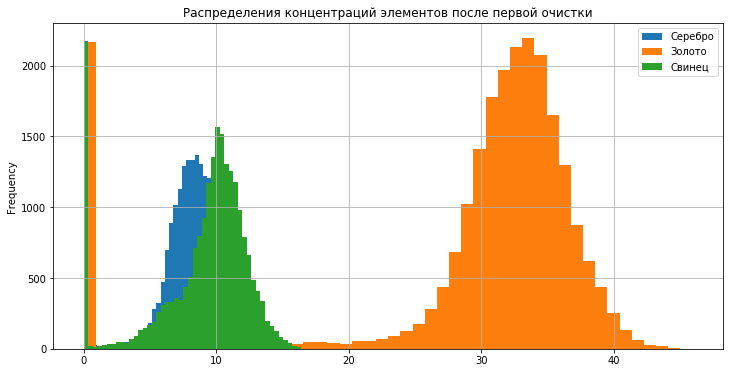

In [18]:
for elem in ['ag', 'au', 'pb']:
    
    
    df_full['primary_cleaner.output.concentrate_'+elem].plot(figsize=[12,6], grid=True, kind='hist', bins=50, title='Распределения концентраций элементов после первой очистки')      
plt.legend(['Серебро', 'Золото', 'Свинец'])

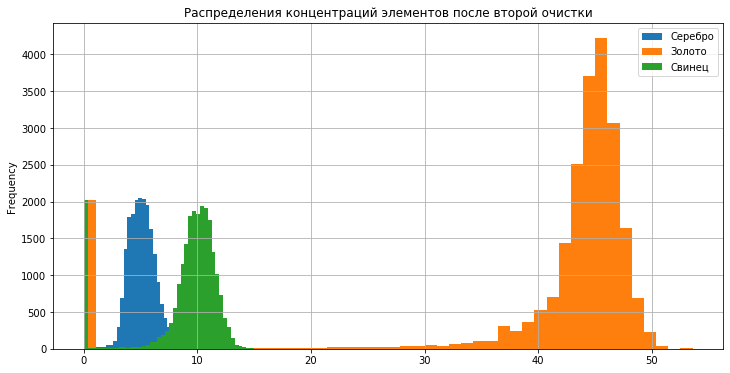

In [19]:
for elem in ['ag', 'au', 'pb']:
    
    
    df_full['final.output.concentrate_'+elem].plot(figsize=[12,6], grid=True, kind='hist', bins=50, title='Распределения концентраций элементов после второй очистки')      
plt.legend(['Серебро', 'Золото', 'Свинец'])

Концентрация золота на каждом этапе очистки росла, концентрация серебра и свинца - падала. Так же по всем трём признакам заметны выбросы, содержащие нулевые значения. 

#### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.


count    15138.000000
mean        59.531156
std         22.938364
min          9.659576
25%         48.226644
50%         54.878415
75%         65.792282
max        484.967466
Name: rougher.input.feed_size, dtype: float64

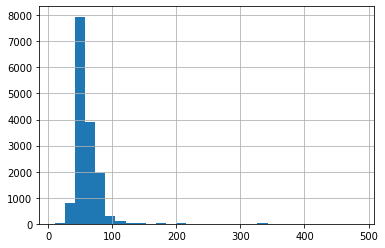

In [20]:
df_train['rougher.input.feed_size'].hist(bins=30)
df_train['rougher.input.feed_size'].describe()

count    5834.000000
mean       55.937535
std        22.724254
min         0.046369
25%        43.890852
50%        50.002004
75%        61.638434
max       477.445473
Name: rougher.input.feed_size, dtype: float64

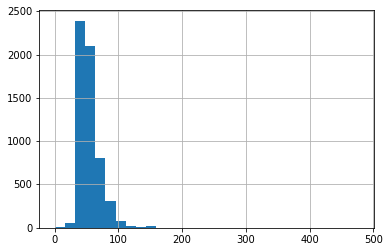

In [21]:
df_test['rougher.input.feed_size'].hist(bins=30)
df_test['rougher.input.feed_size'].describe()


Распределения размеров гранул сырья на тестовой и обучающей выборках практически идентичны. Значимых расхождений не обнаружено. Выбросы по данному признаку очистим на более позднем этапе.

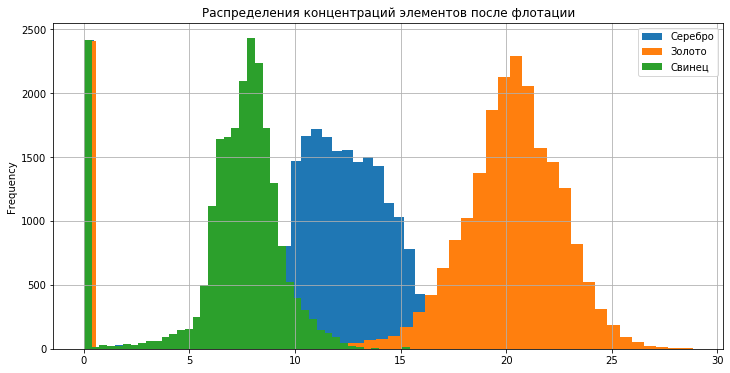

In [22]:
for elem in ['ag', 'au', 'pb']:
    
    
    df_full['rougher.output.concentrate_'+elem].plot(figsize=[12,6], kind='hist', bins=50, grid=True, title='Распределения концентраций элементов после флотации')      
plt.legend(['Серебро', 'Золото', 'Свинец'])

#### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [23]:
# Создадим столбцы с суммарной концентрацией всех веществ для каждой стадии:
for stage in ['rougher', 'primary_cleaner', 'final']:

    df_full[stage+'.output.concentrate_sum'] = sum(df_full[stage+'.output.concentrate_'+elem] 
                                                 for elem in ['ag', 'au', 'pb', 'sol'])

Text(0.5, 1.0, 'Распределение суммарных концентраций всех веществ на каждой стадии очистки')

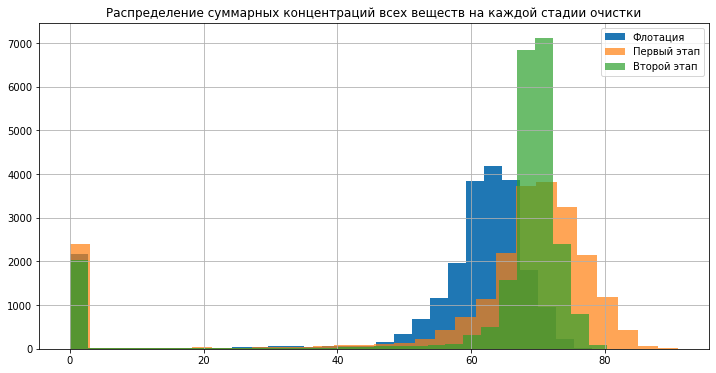

In [24]:

ax = df_full['primary_cleaner.output.concentrate_sum'].hist(grid=True, figsize=[12, 6], bins=30, alpha=1)
df_full['rougher.output.concentrate_sum'].hist(bins=30,ax=ax, alpha=0.7)
df_full['final.output.concentrate_sum'].hist(bins=30, ax=ax, alpha=0.7)

plt.legend(['Флотация', 'Первый этап', 'Второй этап'])
plt.title('Распределение суммарных концентраций всех веществ на каждой стадии очистки')

Распределение суммарных концентраций веществ симметрично, унимодально, если не считать выбросов около нулевых значений. Нулевые значения могут быть связаны с ошибками измерений или простоями. Данные, полученные в этот период, удалим на следующем этапе, поскольку они выглядят как заведомо ошибочные.

In [25]:

df_train.shape

(15367, 87)

In [26]:
df_test.shape

(5856, 52)

In [27]:
df_full.shape

(22716, 90)

Оценим размеры выборок перед тем как заняться их окончательной очисткой. Почти всё на месте. Пока что.

### Дополнительно обработаем данные:

In [28]:
# Для этого создадим необходимые функции:

def spikes_drop(data, columns_list, distance):
    
        
    """
    Функция, отсекающая выбросы по усам boxplot:
    
    data - обрабатываемый датафрейм
    columns_list - список колонок, подлежащих обработке
     
    На выход функция выдаст датафрейм, от которого отсечены выбросы
    
    """ 

    for column in columns_list:
        
        print('Ящик с усами для {}:'.format(column))
        data.boxplot(column=column)
        plt.show()
        upper_whisker = data[column].quantile(q = 0.75) + distance*(data[column].quantile(q = 0.75) - 
        data[column].quantile(q = 0.25))
        print('Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра {}:'.format(column), 
              upper_whisker
             )
        
        print('Значений сверху отсечено: {}'.format(data[data[column] > upper_whisker][column].count()))
        data = data[data[column] < upper_whisker]
              
        lower_whisker = data[column].quantile(q = 0.25) - distance*(data[column].quantile(q = 0.75) - 
        data[column].quantile(q = 0.25))
              
        print('Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра {}:'.format(column), 
              lower_whisker
             )
        print('Значений снизу отсечено: {}'.format(data[data[column] < lower_whisker][column].count()))
       
        data = data[data[column] > lower_whisker]
        
        
              
        print('Проверка отсечения выбросов для {}:'.format(column))
        data.boxplot(column=column)
        plt.show()
    
    return data



Создадим ряд функций, необходимых нам для обработки выборок. Более подробное содержание каждой из них поместим в код для удобства дальнейшего их использования.

In [73]:
df_train.std().sort_values(ascending=False).head(30)

primary_cleaner.state.floatbank8_d_air        281.117966
rougher.state.floatbank10_c_air               198.624584
rougher.state.floatbank10_d_air               196.547686
rougher.state.floatbank10_e_air               181.866937
rougher.state.floatbank10_b_air               171.214751
rougher.state.floatbank10_f_air               169.162625
rougher.state.floatbank10_a_air               165.152391
primary_cleaner.state.floatbank8_c_air        134.132692
primary_cleaner.state.floatbank8_b_air        131.749019
primary_cleaner.state.floatbank8_a_air        128.695224
rougher.state.floatbank10_a_level              95.227966
rougher.input.feed_rate                        88.124402
secondary_cleaner.state.floatbank4_b_level     58.186709
secondary_cleaner.state.floatbank3_a_level     55.217107
rougher.state.floatbank10_b_level              52.754633
secondary_cleaner.state.floatbank2_a_level     52.053692
rougher.state.floatbank10_e_level              51.609564
rougher.state.floatbank10_f_lev

Ящик с усами для rougher.calculation.sulfate_to_au_concentrate:


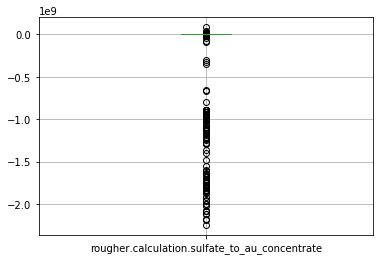

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.calculation.sulfate_to_au_concentrate: 60534.81808613339
Значений сверху отсечено: 806
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.calculation.sulfate_to_au_concentrate: 27448.851331866954
Значений снизу отсечено: 1847
Проверка отсечения выбросов для rougher.calculation.sulfate_to_au_concentrate:


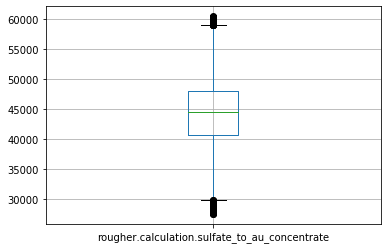

Ящик с усами для rougher.calculation.floatbank10_sulfate_to_au_feed:


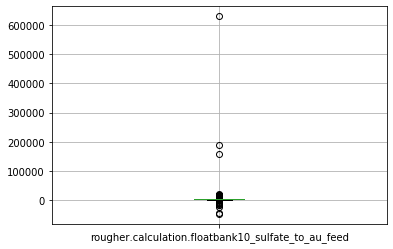

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.calculation.floatbank10_sulfate_to_au_feed: 5265.424055298184
Значений сверху отсечено: 1210
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.calculation.floatbank10_sulfate_to_au_feed: 1111.845529553893
Значений снизу отсечено: 245
Проверка отсечения выбросов для rougher.calculation.floatbank10_sulfate_to_au_feed:


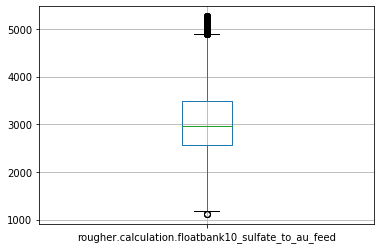

Ящик с усами для rougher.calculation.floatbank11_sulfate_to_au_feed:


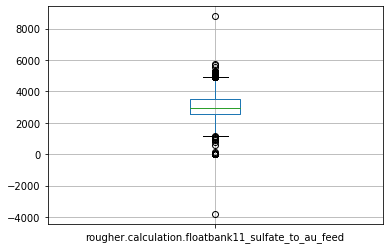

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.calculation.floatbank11_sulfate_to_au_feed: 4895.052366169489
Значений сверху отсечено: 360
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.calculation.floatbank11_sulfate_to_au_feed: 1185.3621581533664
Значений снизу отсечено: 31
Проверка отсечения выбросов для rougher.calculation.floatbank11_sulfate_to_au_feed:


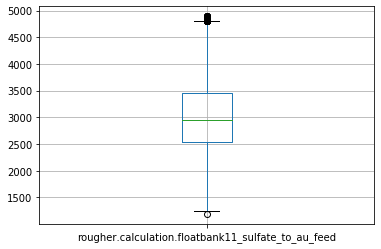

Ящик с усами для primary_cleaner.state.floatbank8_d_air:


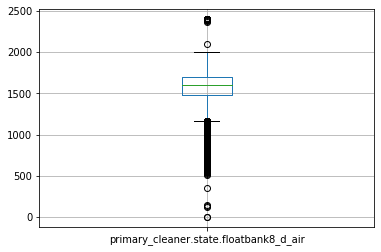

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_d_air: 2010.7574009127181
Значений сверху отсечено: 381
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_d_air: 1166.7757409857932
Значений снизу отсечено: 925
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_d_air:


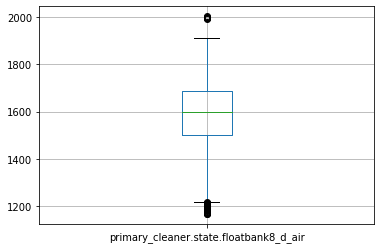

Ящик с усами для primary_cleaner.state.floatbank8_c_air:


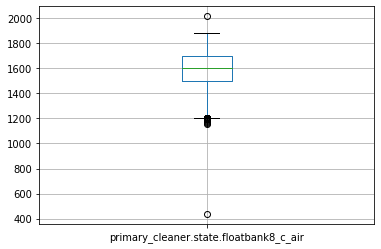

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_c_air: 1997.3818657391248
Значений сверху отсечено: 1
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_c_air: 1202.467048340269
Значений снизу отсечено: 264
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_c_air:


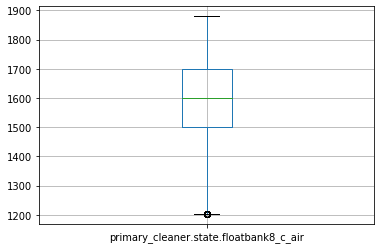

Ящик с усами для primary_cleaner.state.floatbank8_b_air:


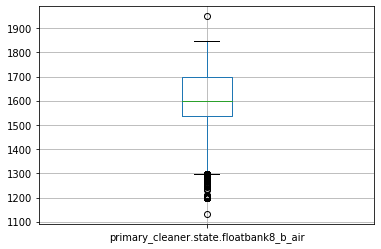

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_b_air: 1941.3163487813435
Значений сверху отсечено: 1
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_b_air: 1295.8586679846003
Значений снизу отсечено: 132
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_b_air:


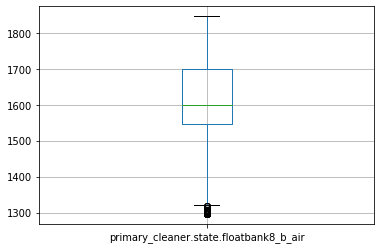

Ящик с усами для primary_cleaner.state.floatbank8_a_air:


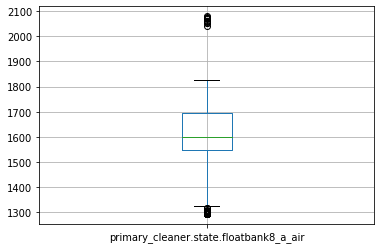

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_a_air: 1922.6220675494574
Значений сверху отсечено: 12
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_a_air: 1320.755579179031
Значений снизу отсечено: 375
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_a_air:


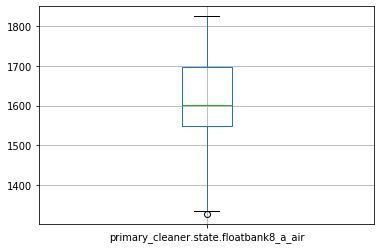

Ящик с усами для rougher.state.floatbank10_c_air:


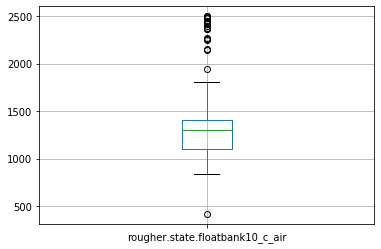

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_c_air: 1856.6334252657516
Значений сверху отсечено: 21
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_c_air: 648.2759786237474
Значений снизу отсечено: 1
Проверка отсечения выбросов для rougher.state.floatbank10_c_air:


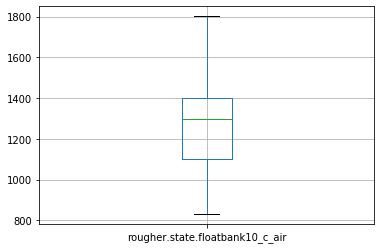

Ящик с усами для rougher.state.floatbank10_b_air:


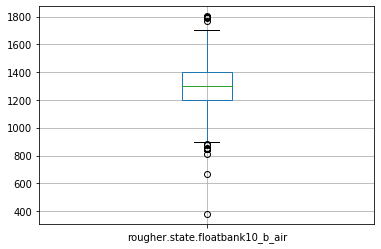

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_b_air: 1709.3735803103232
Значений сверху отсечено: 18
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_b_air: 892.1078853498069
Значений снизу отсечено: 16
Проверка отсечения выбросов для rougher.state.floatbank10_b_air:


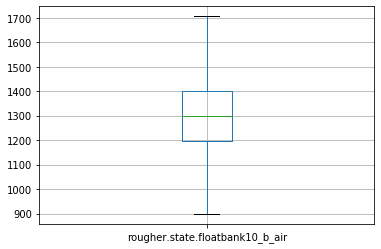

Ящик с усами для rougher.state.floatbank10_d_air:


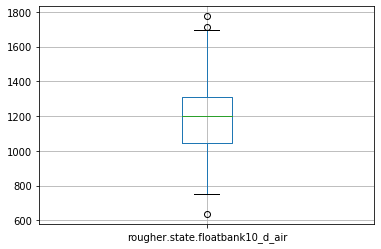

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_d_air: 1704.3709955067338
Значений сверху отсечено: 2
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_d_air: 651.2038894937614
Значений снизу отсечено: 1
Проверка отсечения выбросов для rougher.state.floatbank10_d_air:


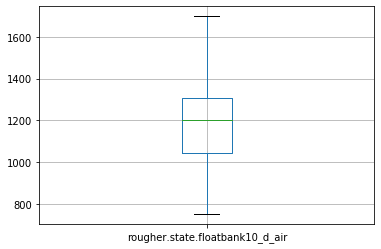

Ящик с усами для rougher.state.floatbank10_e_air:


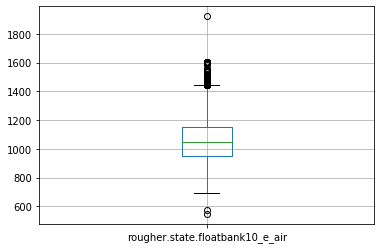

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_e_air: 1445.6528553883088
Значений сверху отсечено: 447
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_e_air: 724.8978020241211
Значений снизу отсечено: 90
Проверка отсечения выбросов для rougher.state.floatbank10_e_air:


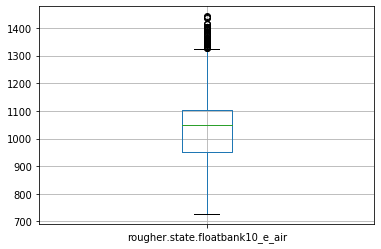

Ящик с усами для rougher.state.floatbank10_a_air:


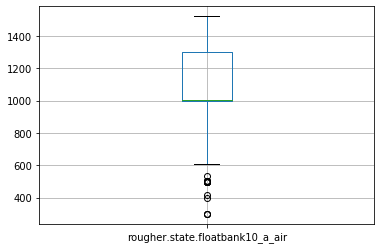

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_a_air: 1746.8625071555493
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_a_air: 551.3798194989355
Значений снизу отсечено: 16
Проверка отсечения выбросов для rougher.state.floatbank10_a_air:


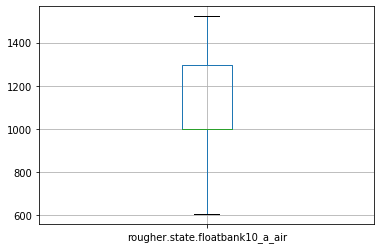

Ящик с усами для rougher.state.floatbank10_f_air:


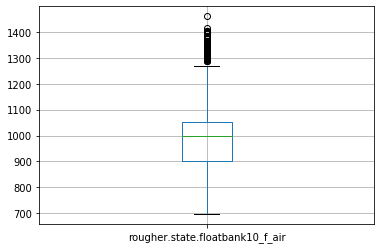

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_f_air: 1275.4667583922499
Значений сверху отсечено: 519
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_f_air: 678.4299751719178
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.state.floatbank10_f_air:


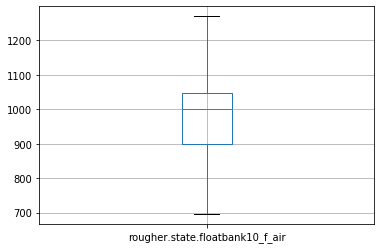

Ящик с усами для rougher.input.feed_rate:


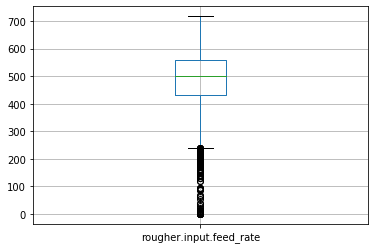

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_rate: 751.2973538040662
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_rate: 239.1822492909784
Значений снизу отсечено: 184
Проверка отсечения выбросов для rougher.input.feed_rate:


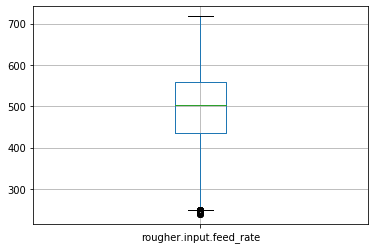

Ящик с усами для rougher.state.floatbank10_a_level:


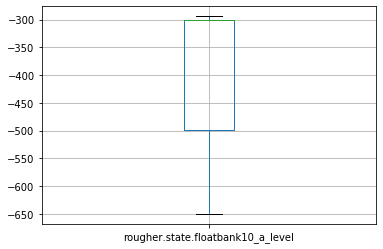

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_a_level: -0.35811017474310347
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_a_level: -799.3000502106529
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.state.floatbank10_a_level:


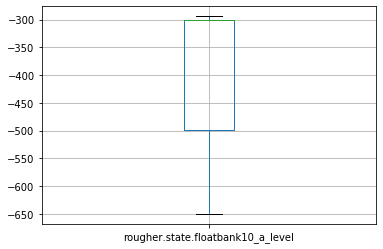

Ящик с усами для secondary_cleaner.state.floatbank4_b_level:


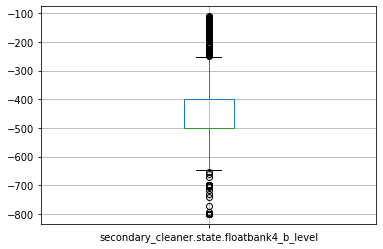

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_b_level: -250.25683321729227
Значений сверху отсечено: 223
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_b_level: -650.028163868268
Значений снизу отсечено: 86
Проверка отсечения выбросов для secondary_cleaner.state.floatbank4_b_level:


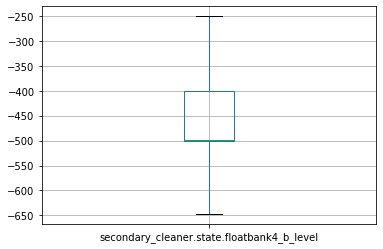

Ящик с усами для secondary_cleaner.state.floatbank2_b_level:


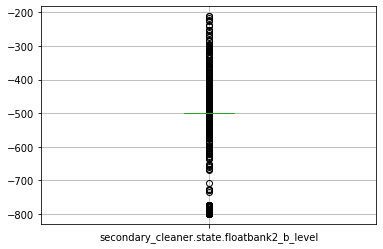

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_b_level: -499.1251908173366
Значений сверху отсечено: 1147
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_b_level: -500.84151966750665
Значений снизу отсечено: 943
Проверка отсечения выбросов для secondary_cleaner.state.floatbank2_b_level:


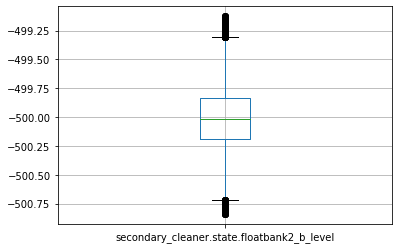

Ящик с усами для secondary_cleaner.state.floatbank2_a_level:


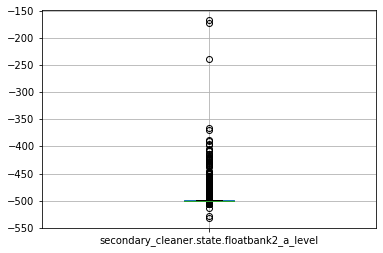

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_a_level: -499.13540502963735
Значений сверху отсечено: 712
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_a_level: -500.783181243974
Значений снизу отсечено: 539
Проверка отсечения выбросов для secondary_cleaner.state.floatbank2_a_level:


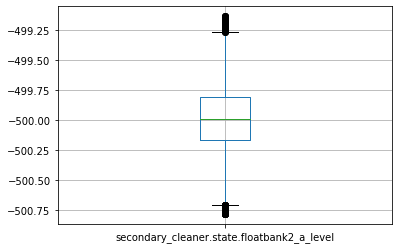

Ящик с усами для secondary_cleaner.state.floatbank3_a_level:


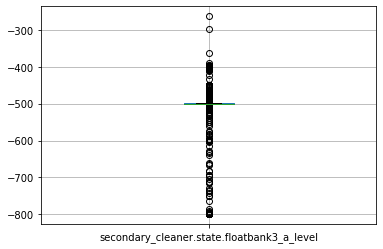

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_a_level: -498.48087792798833
Значений сверху отсечено: 2056
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_a_level: -500.8875401312508
Значений снизу отсечено: 634
Проверка отсечения выбросов для secondary_cleaner.state.floatbank3_a_level:


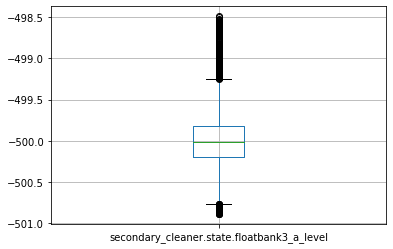

Ящик с усами для primary_cleaner.state.floatbank8_d_level:


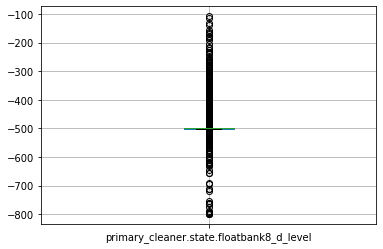

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_d_level: -497.57384106218126
Значений сверху отсечено: 1085
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_d_level: -501.9420806734928
Значений снизу отсечено: 584
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_d_level:


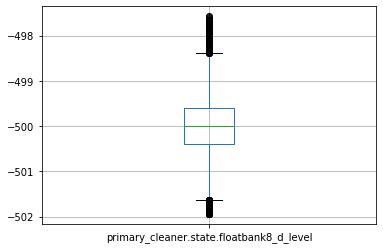

Ящик с усами для secondary_cleaner.state.floatbank4_a_level:


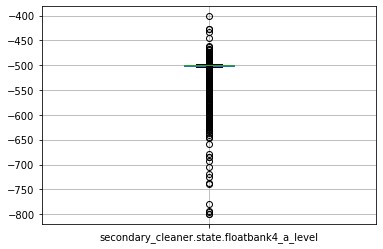

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_a_level: -497.3321696251113
Значений сверху отсечено: 218
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_a_level: -502.8096383849677
Значений снизу отсечено: 439
Проверка отсечения выбросов для secondary_cleaner.state.floatbank4_a_level:


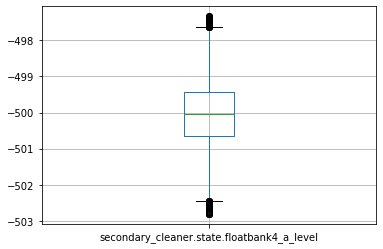

Ящик с усами для secondary_cleaner.state.floatbank5_b_level:


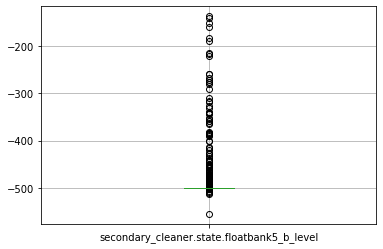

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_b_level: -499.39082327326906
Значений сверху отсечено: 374
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_b_level: -500.5770096226224
Значений снизу отсечено: 169
Проверка отсечения выбросов для secondary_cleaner.state.floatbank5_b_level:


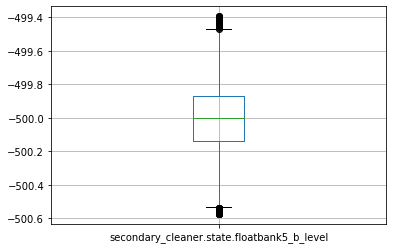

Ящик с усами для primary_cleaner.state.floatbank8_b_level:


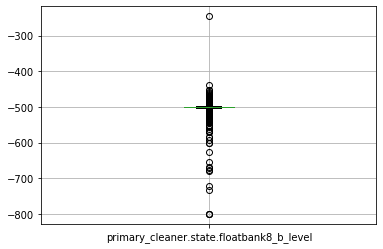

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_b_level: -498.3341401825279
Значений сверху отсечено: 305
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_b_level: -501.6637181452986
Значений снизу отсечено: 340
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_b_level:


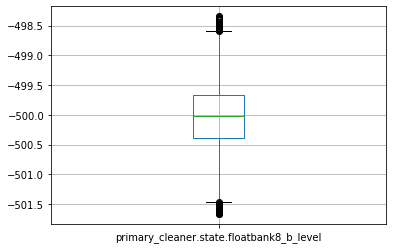

Ящик с усами для secondary_cleaner.state.floatbank6_a_level:


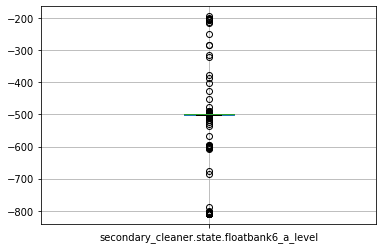

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank6_a_level: -497.9991442514878
Значений сверху отсечено: 138
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank6_a_level: -502.1887613596024
Значений снизу отсечено: 427
Проверка отсечения выбросов для secondary_cleaner.state.floatbank6_a_level:


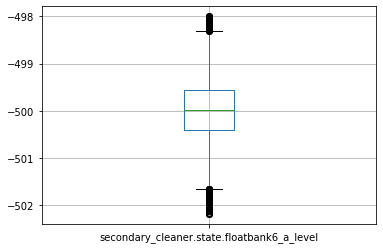

Ящик с усами для primary_cleaner.state.floatbank8_c_level:


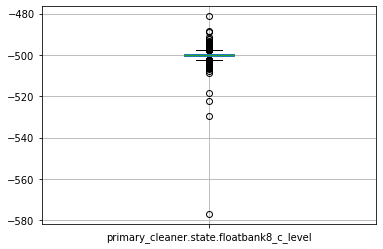

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_c_level: -497.7339017440727
Значений сверху отсечено: 135
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_c_level: -502.2445050568606
Значений снизу отсечено: 143
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_c_level:


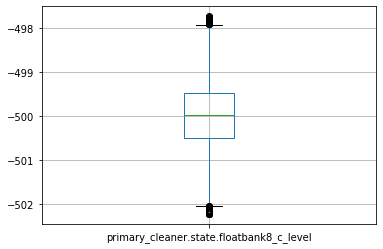

Ящик с усами для primary_cleaner.state.floatbank8_a_level:


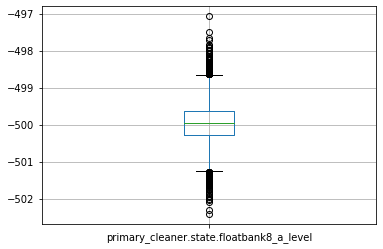

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_a_level: -498.6483073826054
Значений сверху отсечено: 71
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_a_level: -501.2553234212901
Значений снизу отсечено: 68
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_a_level:


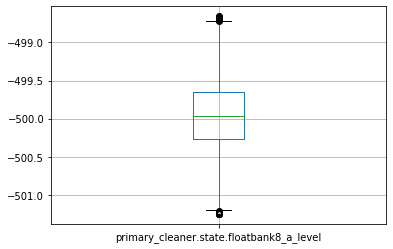

Ящик с усами для secondary_cleaner.state.floatbank5_a_level:


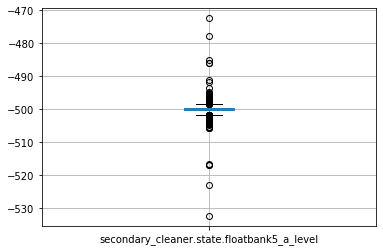

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_a_level: -498.3351534579009
Значений сверху отсечено: 91
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_a_level: -501.6350430984978
Значений снизу отсечено: 101
Проверка отсечения выбросов для secondary_cleaner.state.floatbank5_a_level:


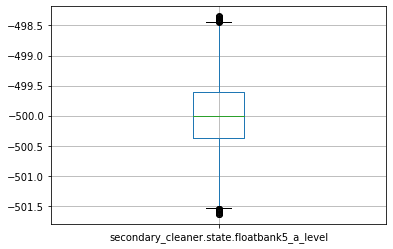

Ящик с усами для secondary_cleaner.state.floatbank3_b_level:


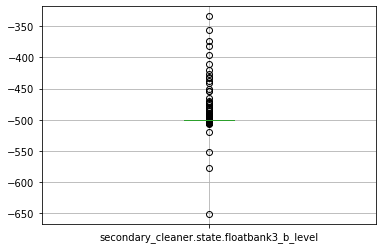

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_b_level: -499.5859465915144
Значений сверху отсечено: 134
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_b_level: -500.38342782743644
Значений снизу отсечено: 133
Проверка отсечения выбросов для secondary_cleaner.state.floatbank3_b_level:


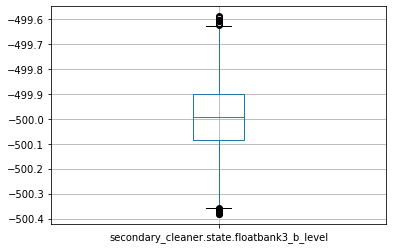

Ящик с усами для rougher.state.floatbank10_f_level:


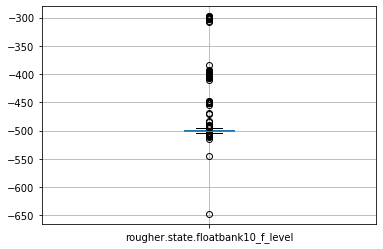

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_f_level: -495.13998533870034
Значений сверху отсечено: 551
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_f_level: -503.0750918191004
Значений снизу отсечено: 48
Проверка отсечения выбросов для rougher.state.floatbank10_f_level:


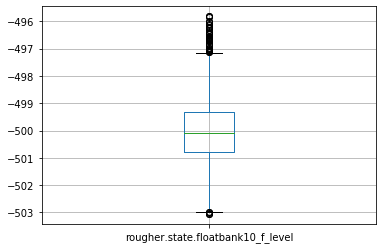

Ящик с усами для rougher.state.floatbank10_e_level:


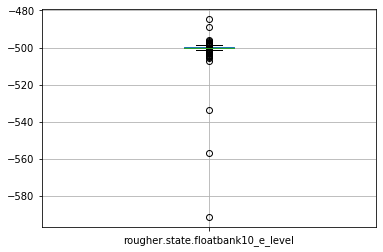

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_e_level: -498.5415986332198
Значений сверху отсечено: 52
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_e_level: -501.4286632876589
Значений снизу отсечено: 58
Проверка отсечения выбросов для rougher.state.floatbank10_e_level:


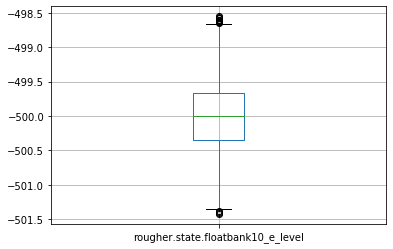

Ящик с усами для rougher.state.floatbank10_b_level:


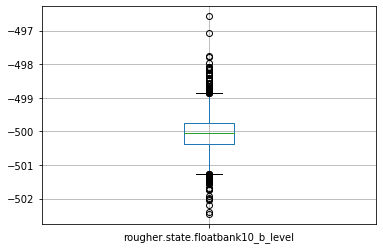

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_b_level: -498.8563860123262
Значений сверху отсечено: 49
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_b_level: -501.25775366883795
Значений снизу отсечено: 40
Проверка отсечения выбросов для rougher.state.floatbank10_b_level:


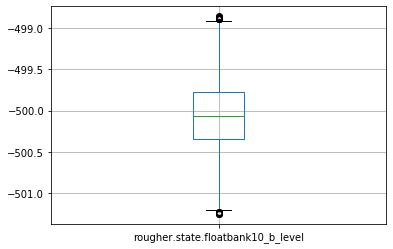

Ящик с усами для rougher.state.floatbank10_c_level:


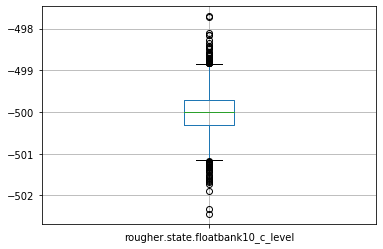

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_c_level: -498.8425928137041
Значений сверху отсечено: 37
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_c_level: -501.1575027186303
Значений снизу отсечено: 40
Проверка отсечения выбросов для rougher.state.floatbank10_c_level:


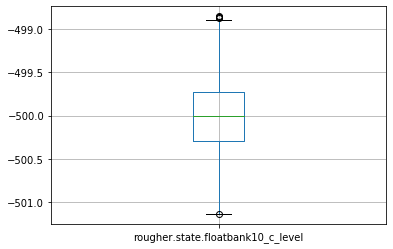

Ящик с усами для rougher.state.floatbank10_d_level:


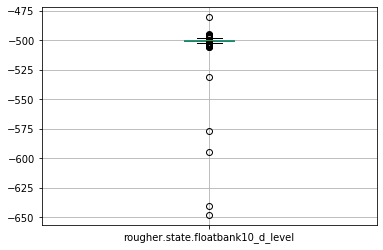

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_d_level: -497.5864960350076
Значений сверху отсечено: 60
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_d_level: -502.47977115126344
Значений снизу отсечено: 67
Проверка отсечения выбросов для rougher.state.floatbank10_d_level:


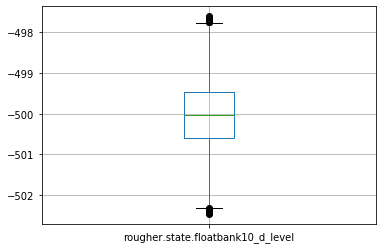

Ящик с усами для primary_cleaner.input.sulfate:


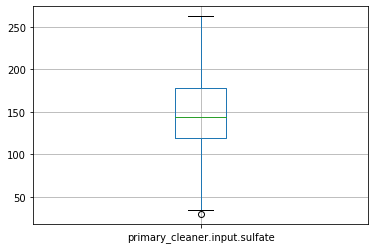

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.input.sulfate: 266.66395612179736
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.input.sulfate: 30.45553617042745
Значений снизу отсечено: 1
Проверка отсечения выбросов для primary_cleaner.input.sulfate:


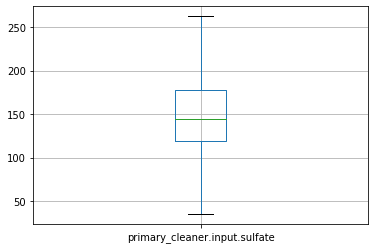

Ящик с усами для rougher.input.feed_size:


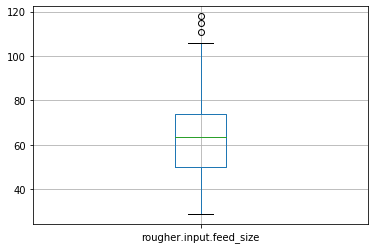

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_size: 109.42328212689257
Значений сверху отсечено: 3
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_size: 14.290742718411188
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.input.feed_size:


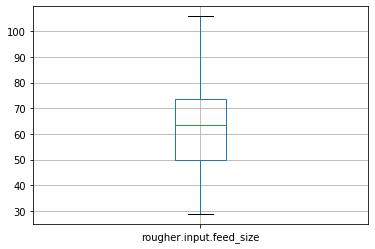

Ящик с усами для rougher.output.concentrate_sum:


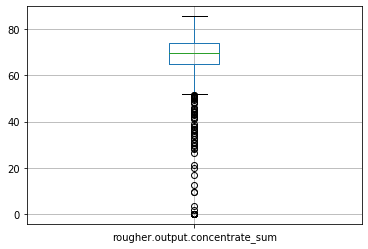

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.output.concentrate_sum: 87.20017300866945
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.output.concentrate_sum: 51.59066509506945
Значений снизу отсечено: 82
Проверка отсечения выбросов для rougher.output.concentrate_sum:


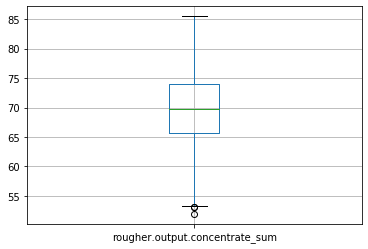

Ящик с усами для final.output.concentrate_sum:


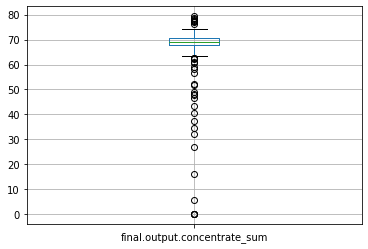

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра final.output.concentrate_sum: 75.03290627930171
Значений сверху отсечено: 8
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра final.output.concentrate_sum: 63.41665372506333
Значений снизу отсечено: 27
Проверка отсечения выбросов для final.output.concentrate_sum:


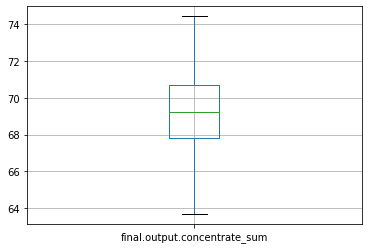

Ящик с усами для primary_cleaner.output.concentrate_sum:


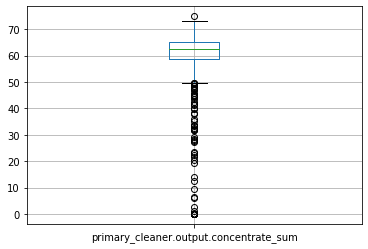

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.output.concentrate_sum: 74.35055773679436
Значений сверху отсечено: 1
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.output.concentrate_sum: 49.55736632583983
Значений снизу отсечено: 79
Проверка отсечения выбросов для primary_cleaner.output.concentrate_sum:


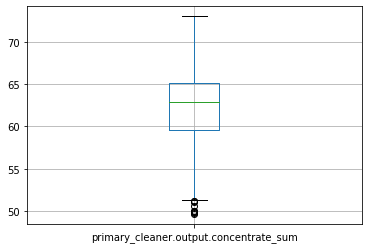

Ящик с усами для final.output.concentrate_au:


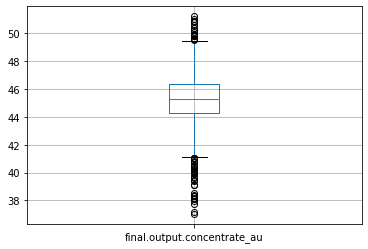

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра final.output.concentrate_au: 49.54707883665274
Значений сверху отсечено: 19
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра final.output.concentrate_au: 41.12015863813275
Значений снизу отсечено: 36
Проверка отсечения выбросов для final.output.concentrate_au:


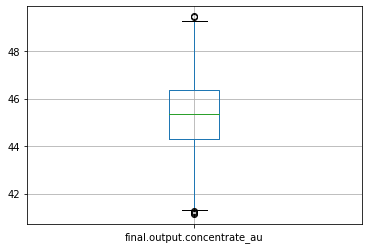

Ящик с усами для final.output.recovery:


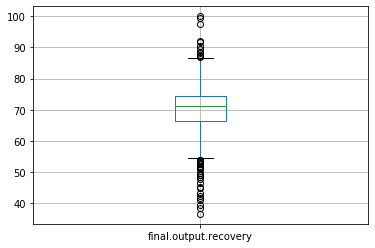

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра final.output.recovery: 86.57462573416606
Значений сверху отсечено: 12
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра final.output.recovery: 54.39031280408668
Значений снизу отсечено: 29
Проверка отсечения выбросов для final.output.recovery:


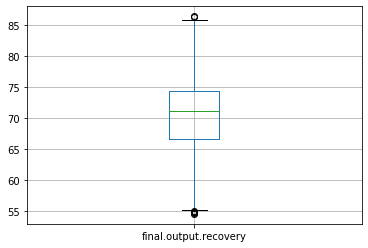

Ящик с усами для rougher.input.feed_sol:


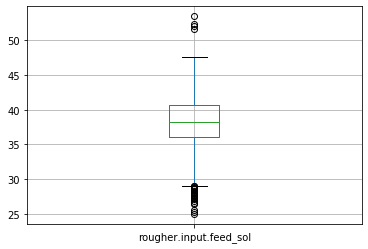

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_sol: 47.68976272741953
Значений сверху отсечено: 4
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_sol: 29.049923848046227
Значений снизу отсечено: 25
Проверка отсечения выбросов для rougher.input.feed_sol:


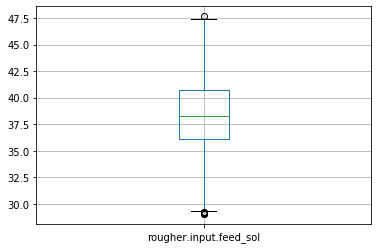

Ящик с усами для primary_cleaner.output.concentrate_au:


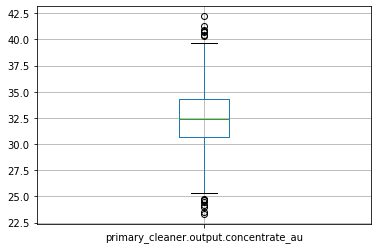

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.output.concentrate_au: 39.71887985953695
Значений сверху отсечено: 7
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.output.concentrate_au: 25.275361625085438
Значений снизу отсечено: 8
Проверка отсечения выбросов для primary_cleaner.output.concentrate_au:


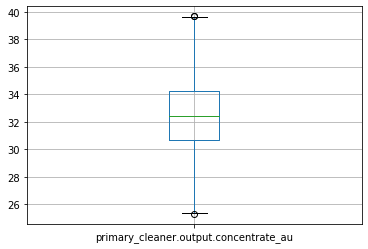

Ящик с усами для rougher.output.concentrate_sol:


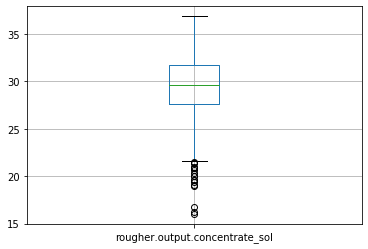

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.output.concentrate_sol: 37.807005489210454
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.output.concentrate_sol: 21.566059220157012
Значений снизу отсечено: 18
Проверка отсечения выбросов для rougher.output.concentrate_sol:


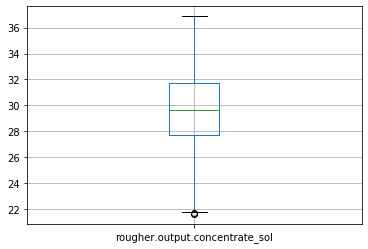

Ящик с усами для secondary_cleaner.state.floatbank3_a_air:


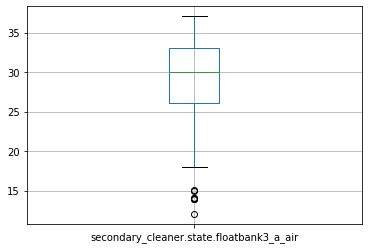

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_a_air: 43.52194552489296
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_a_air: 15.52955269203864
Значений снизу отсечено: 8
Проверка отсечения выбросов для secondary_cleaner.state.floatbank3_a_air:


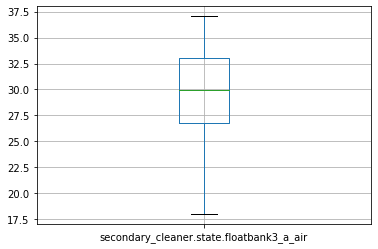

Ящик с усами для secondary_cleaner.state.floatbank2_a_air:


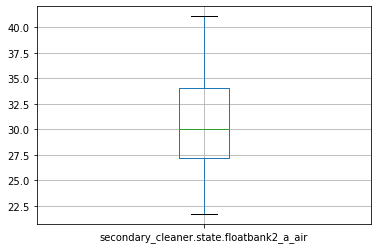

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_a_air: 44.52577877526058
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_a_air: 16.724069572256056
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank2_a_air:


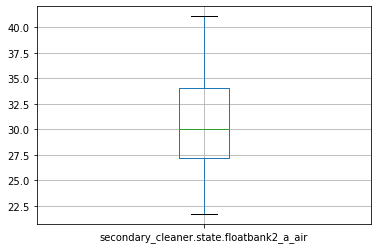

Ящик с усами для secondary_cleaner.state.floatbank2_b_air:


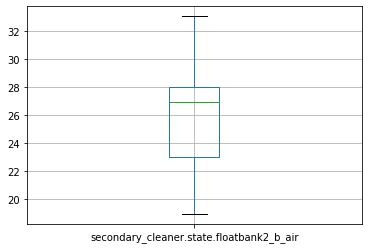

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_b_air: 35.44820554154319
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_b_air: 15.541356738679323
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank2_b_air:


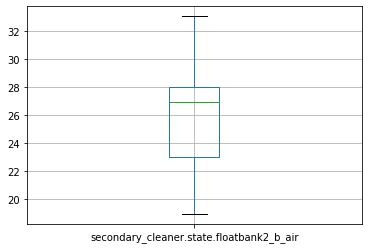

Ящик с усами для secondary_cleaner.state.floatbank3_b_air:


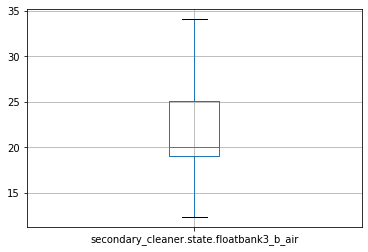

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_b_air: 34.041333884278295
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_b_air: 9.975730116814384
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank3_b_air:


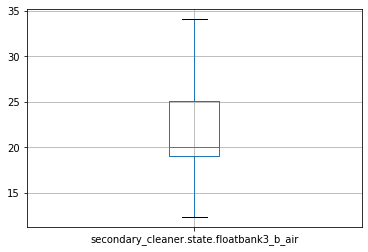

Ящик с усами для rougher.output.concentrate_au:


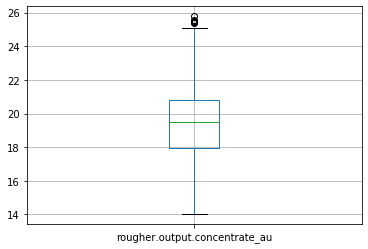

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.output.concentrate_au: 25.14467658827583
Значений сверху отсечено: 6
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.output.concentrate_au: 13.596495981399212
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.output.concentrate_au:


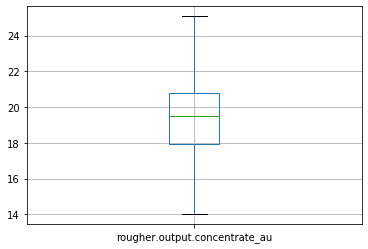

Ящик с усами для secondary_cleaner.state.floatbank6_a_air:


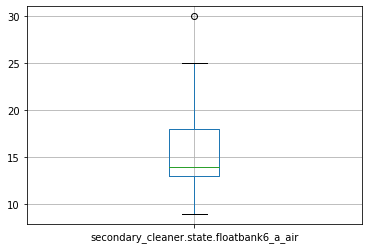

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank6_a_air: 25.56832262118123
Значений сверху отсечено: 1
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank6_a_air: 5.411269430515061
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank6_a_air:


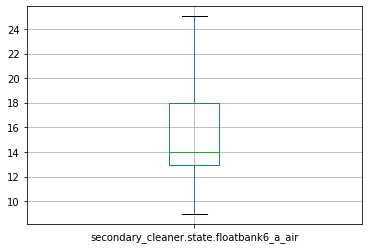

Ящик с усами для secondary_cleaner.state.floatbank4_a_air:


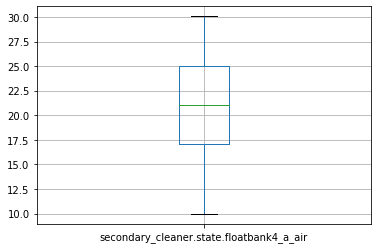

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_a_air: 36.9391548259767
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_a_air: 5.092783392858635
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank4_a_air:


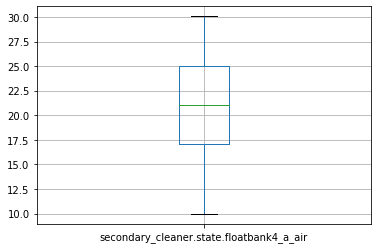

Ящик с усами для rougher.calculation.sulfate_to_au_concentrate:


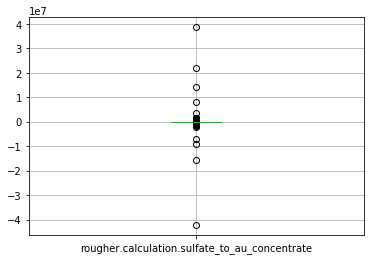

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.calculation.sulfate_to_au_concentrate: 59844.46047045011
Значений сверху отсечено: 533
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.calculation.sulfate_to_au_concentrate: 28918.03356629003
Значений снизу отсечено: 585
Проверка отсечения выбросов для rougher.calculation.sulfate_to_au_concentrate:


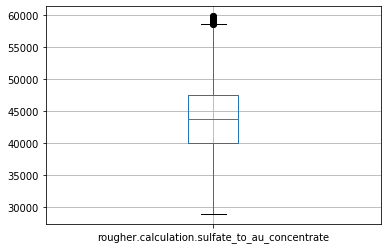

Ящик с усами для rougher.calculation.floatbank11_sulfate_to_au_feed:


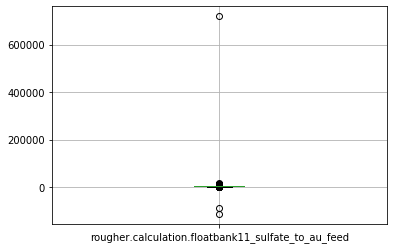

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.calculation.floatbank11_sulfate_to_au_feed: 5137.193877849494
Значений сверху отсечено: 784
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.calculation.floatbank11_sulfate_to_au_feed: 1152.4172079586535
Значений снизу отсечено: 451
Проверка отсечения выбросов для rougher.calculation.floatbank11_sulfate_to_au_feed:


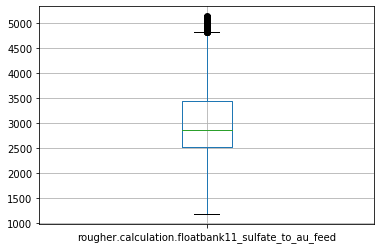

Ящик с усами для rougher.calculation.floatbank10_sulfate_to_au_feed:


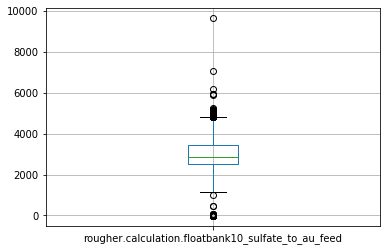

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.calculation.floatbank10_sulfate_to_au_feed: 4809.587935521142
Значений сверху отсечено: 260
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.calculation.floatbank10_sulfate_to_au_feed: 1209.5287408228437
Значений снизу отсечено: 34
Проверка отсечения выбросов для rougher.calculation.floatbank10_sulfate_to_au_feed:


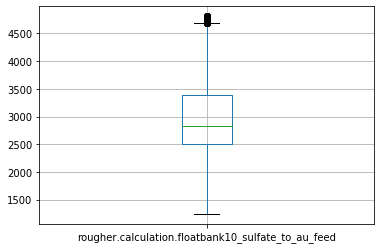

Ящик с усами для primary_cleaner.state.floatbank8_d_air:


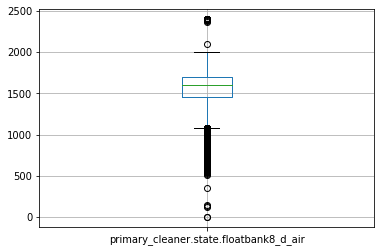

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_d_air: 2070.116527880442
Значений сверху отсечено: 350
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_d_air: 1079.1923079625813
Значений снизу отсечено: 786
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_d_air:


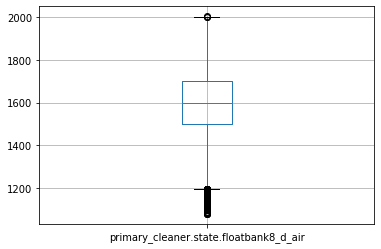

Ящик с усами для primary_cleaner.state.floatbank8_c_air:


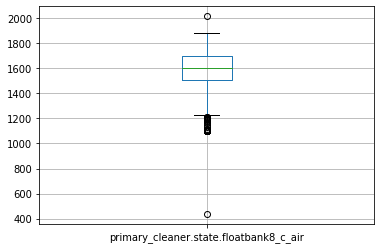

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_c_air: 1993.8325425395196
Значений сверху отсечено: 1
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_c_air: 1211.5277660538331
Значений снизу отсечено: 309
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_c_air:


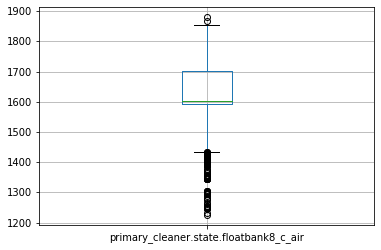

Ящик с усами для rougher.state.floatbank10_c_air:


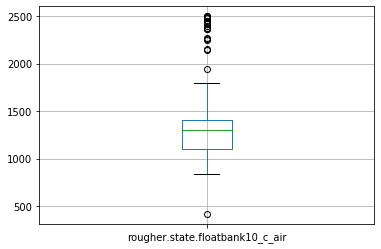

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_c_air: 1853.5756774458603
Значений сверху отсечено: 21
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_c_air: 648.64468583483
Значений снизу отсечено: 1
Проверка отсечения выбросов для rougher.state.floatbank10_c_air:


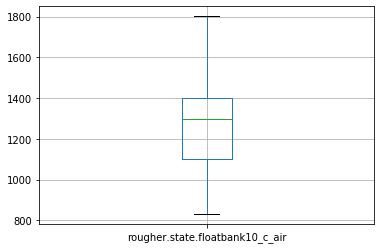

Ящик с усами для primary_cleaner.state.floatbank8_b_air:


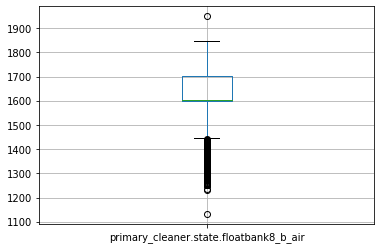

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_b_air: 1855.8233185552936
Значений сверху отсечено: 1
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_b_air: 1442.0848493310427
Значений снизу отсечено: 932
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_b_air:


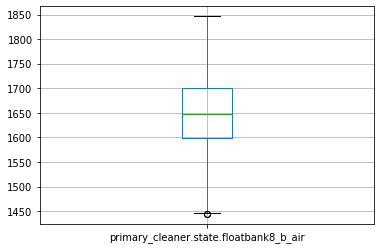

Ящик с усами для primary_cleaner.state.floatbank8_a_air:


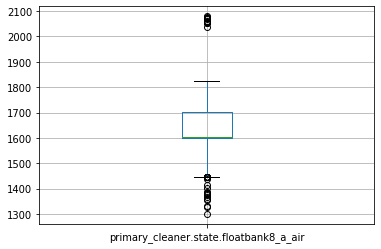

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_a_air: 1852.408162392373
Значений сверху отсечено: 12
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_a_air: 1446.458593922803
Значений снизу отсечено: 23
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_a_air:


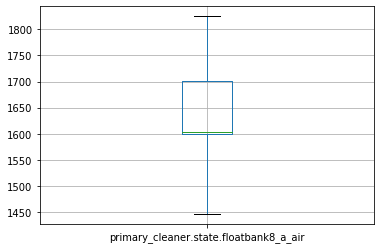

Ящик с усами для rougher.state.floatbank10_d_air:


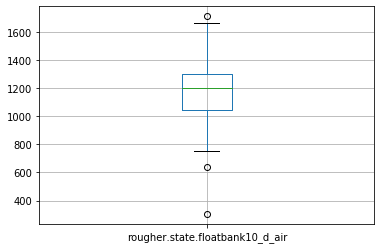

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_d_air: 1683.9898182165693
Значений сверху отсечено: 1
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_d_air: 666.031347029395
Значений снизу отсечено: 2
Проверка отсечения выбросов для rougher.state.floatbank10_d_air:


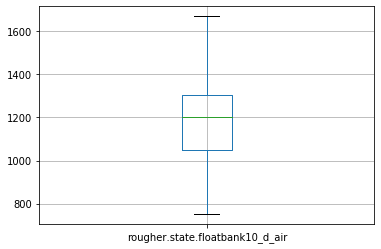

Ящик с усами для rougher.state.floatbank10_b_air:


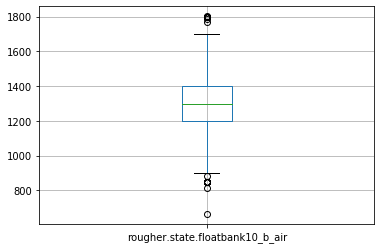

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_b_air: 1709.5843084335772
Значений сверху отсечено: 15
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_b_air: 891.2894805603909
Значений снизу отсечено: 13
Проверка отсечения выбросов для rougher.state.floatbank10_b_air:


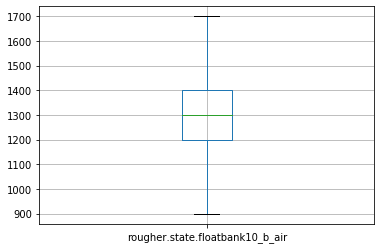

Ящик с усами для rougher.state.floatbank10_e_air:


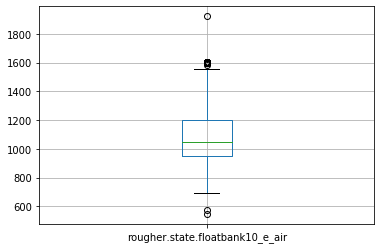

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_e_air: 1568.6606357707994
Значений сверху отсечено: 122
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_e_air: 585.9647489293767
Значений снизу отсечено: 2
Проверка отсечения выбросов для rougher.state.floatbank10_e_air:


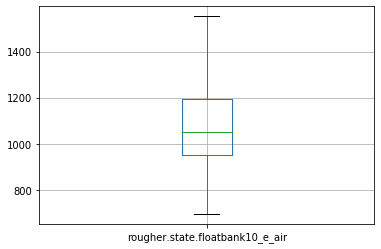

Ящик с усами для rougher.state.floatbank10_a_air:


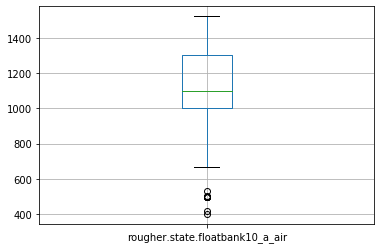

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_a_air: 1750.5107736798216
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_a_air: 549.6132266665406
Значений снизу отсечено: 10
Проверка отсечения выбросов для rougher.state.floatbank10_a_air:


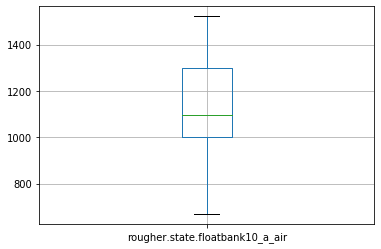

Ящик с усами для rougher.state.floatbank10_f_air:


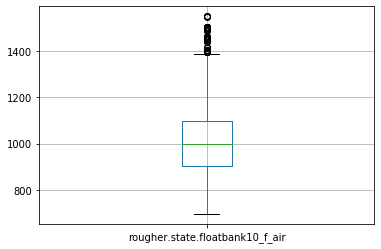

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_f_air: 1394.9194622095124
Значений сверху отсечено: 474
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_f_air: 676.1996942108726
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.state.floatbank10_f_air:


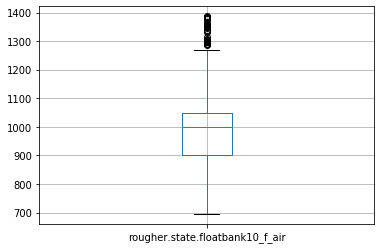

Ящик с усами для rougher.input.feed_rate:


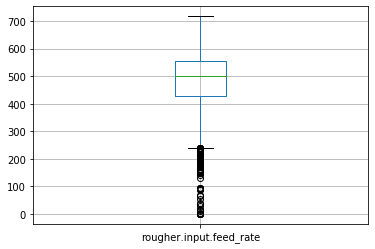

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_rate: 742.3412262521678
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_rate: 239.44431731004497
Значений снизу отсечено: 117
Проверка отсечения выбросов для rougher.input.feed_rate:


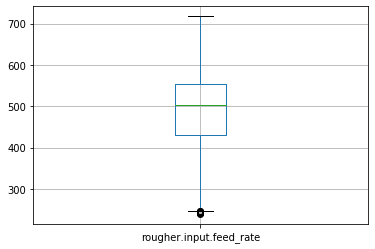

Ящик с усами для rougher.state.floatbank10_a_level:


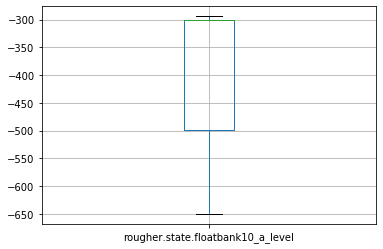

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_a_level: -0.3470348723635652
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_a_level: -799.2661798346971
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.state.floatbank10_a_level:


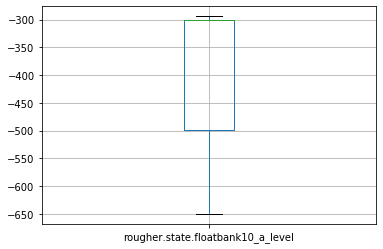

Ящик с усами для secondary_cleaner.state.floatbank2_b_level:


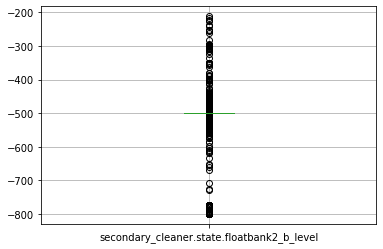

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_b_level: -499.02771152831224
Значений сверху отсечено: 909
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_b_level: -500.87195456717996
Значений снизу отсечено: 626
Проверка отсечения выбросов для secondary_cleaner.state.floatbank2_b_level:


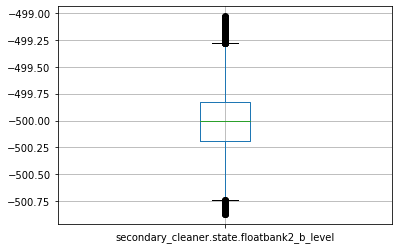

Ящик с усами для secondary_cleaner.state.floatbank2_a_level:


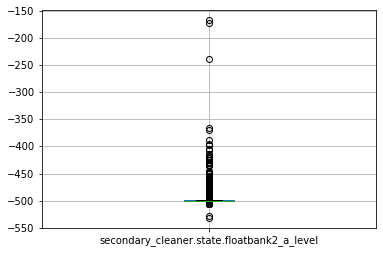

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_a_level: -499.093207266063
Значений сверху отсечено: 467
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_a_level: -500.8122113839685
Значений снизу отсечено: 345
Проверка отсечения выбросов для secondary_cleaner.state.floatbank2_a_level:


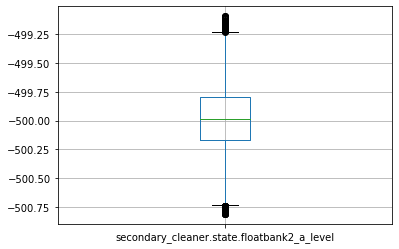

Ящик с усами для secondary_cleaner.state.floatbank3_a_level:


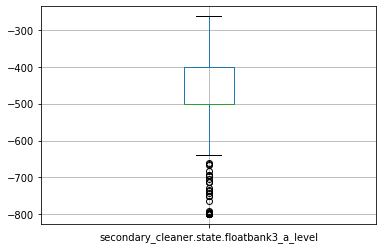

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_a_level: -251.05016217078284
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_a_level: -649.5898249087631
Значений снизу отсечено: 77
Проверка отсечения выбросов для secondary_cleaner.state.floatbank3_a_level:


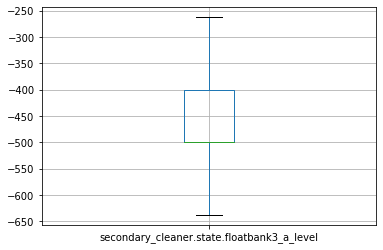

Ящик с усами для secondary_cleaner.state.floatbank4_b_level:


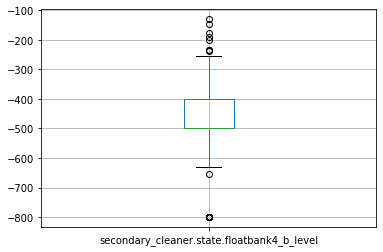

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_b_level: -250.51194432087723
Значений сверху отсечено: 8
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_b_level: -649.8828419510467
Значений снизу отсечено: 25
Проверка отсечения выбросов для secondary_cleaner.state.floatbank4_b_level:


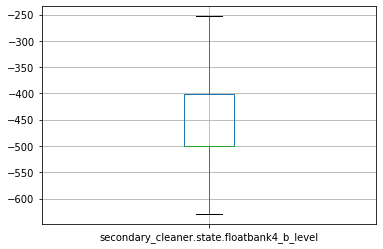

Ящик с усами для secondary_cleaner.state.floatbank4_a_level:


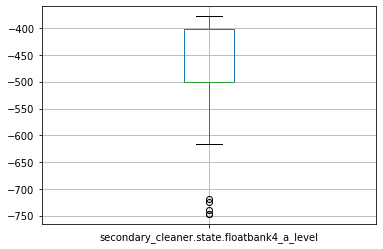

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_a_level: -253.62648769459844
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_a_level: -648.684578354053
Значений снизу отсечено: 5
Проверка отсечения выбросов для secondary_cleaner.state.floatbank4_a_level:


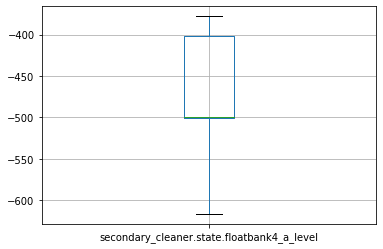

Ящик с усами для primary_cleaner.state.floatbank8_d_level:


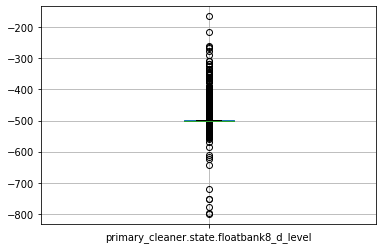

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_d_level: -497.3941739876468
Значений сверху отсечено: 832
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_d_level: -502.09451134181626
Значений снизу отсечено: 469
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_d_level:


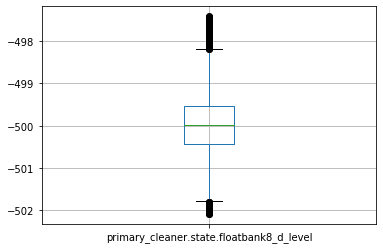

Ящик с усами для rougher.state.floatbank10_b_level:


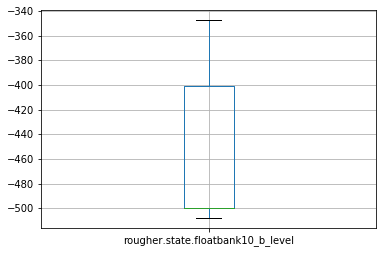

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_b_level: -251.24781168471299
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_b_level: -649.5823809182236
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.state.floatbank10_b_level:


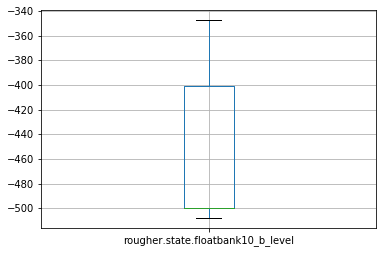

Ящик с усами для rougher.state.floatbank10_f_level:


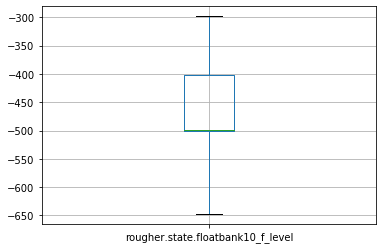

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_f_level: -253.56161634589688
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_f_level: -648.6668695006322
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.state.floatbank10_f_level:


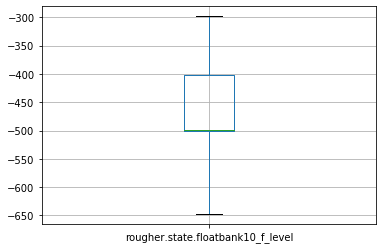

Ящик с усами для rougher.state.floatbank10_e_level:


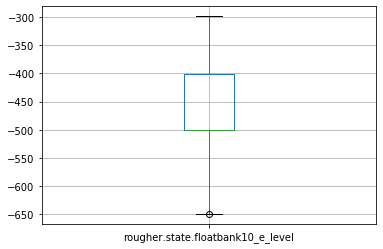

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_e_level: -252.16868093816794
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_e_level: -649.0840788963308
Значений снизу отсечено: 1
Проверка отсечения выбросов для rougher.state.floatbank10_e_level:


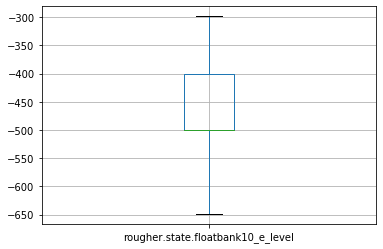

Ящик с усами для rougher.state.floatbank10_c_level:


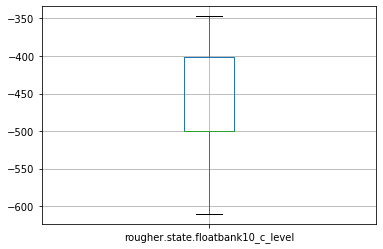

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_c_level: -252.2305222847532
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_c_level: -648.9747532276612
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.state.floatbank10_c_level:


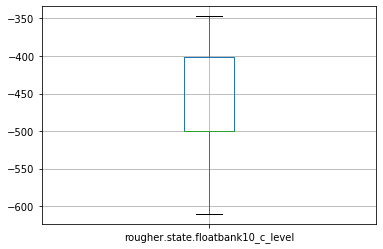

Ящик с усами для rougher.state.floatbank10_d_level:


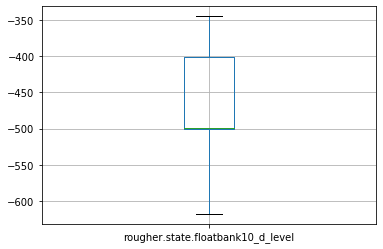

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_d_level: -254.06244668244102
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.state.floatbank10_d_level: -648.2174348389972
Значений снизу отсечено: 0
Проверка отсечения выбросов для rougher.state.floatbank10_d_level:


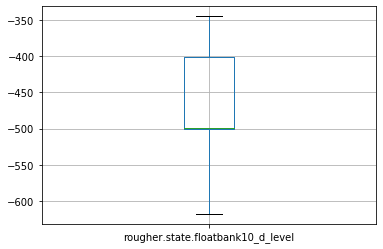

Ящик с усами для secondary_cleaner.state.floatbank3_b_level:


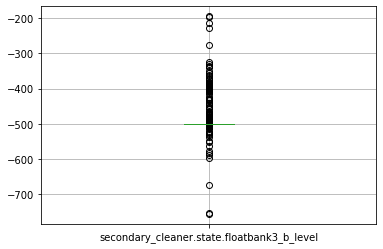

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_b_level: -499.4491618168761
Значений сверху отсечено: 733
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_b_level: -500.4015941584022
Значений снизу отсечено: 224
Проверка отсечения выбросов для secondary_cleaner.state.floatbank3_b_level:


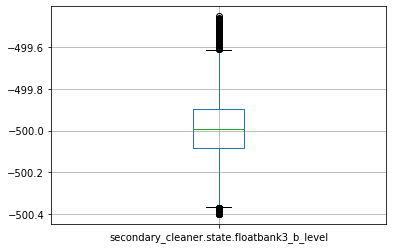

Ящик с усами для secondary_cleaner.state.floatbank5_b_level:


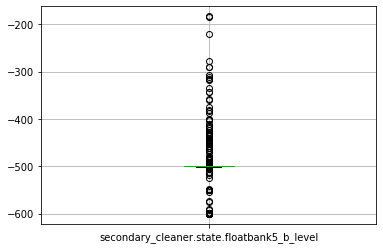

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_b_level: -498.7249818216176
Значений сверху отсечено: 982
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_b_level: -500.5151981660246
Значений снизу отсечено: 181
Проверка отсечения выбросов для secondary_cleaner.state.floatbank5_b_level:


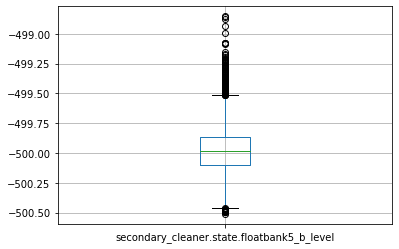

Ящик с усами для primary_cleaner.state.floatbank8_b_level:


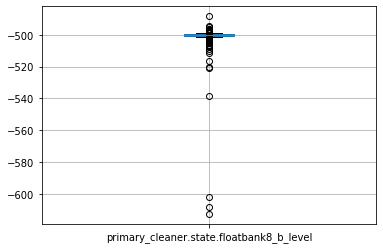

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_b_level: -498.544473088622
Значений сверху отсечено: 46
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_b_level: -501.53131378326543
Значений снизу отсечено: 79
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_b_level:


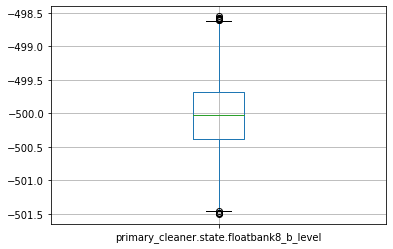

Ящик с усами для primary_cleaner.state.floatbank8_a_level:


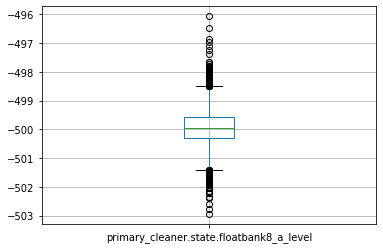

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_a_level: -498.4887790675431
Значений сверху отсечено: 80
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_a_level: -501.393774046997
Значений снизу отсечено: 71
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_a_level:


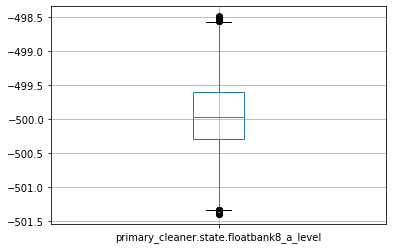

Ящик с усами для primary_cleaner.state.floatbank8_c_level:


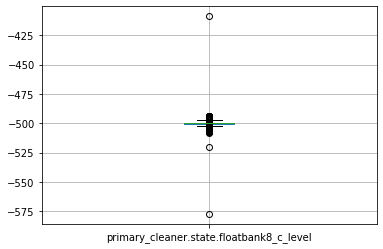

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_c_level: -497.61458984207866
Значений сверху отсечено: 104
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.state.floatbank8_c_level: -502.33165718755055
Значений снизу отсечено: 95
Проверка отсечения выбросов для primary_cleaner.state.floatbank8_c_level:


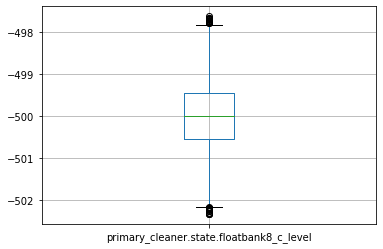

Ящик с усами для secondary_cleaner.state.floatbank6_a_level:


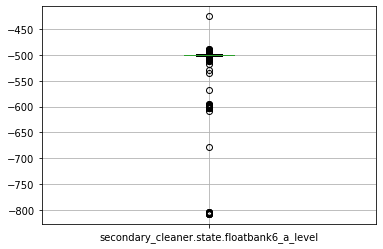

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank6_a_level: -498.0493662661281
Значений сверху отсечено: 61
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank6_a_level: -502.22229734944716
Значений снизу отсечено: 328
Проверка отсечения выбросов для secondary_cleaner.state.floatbank6_a_level:


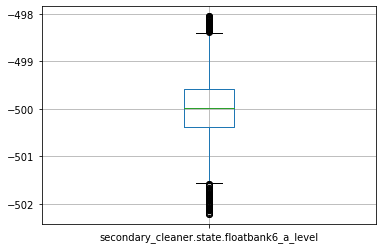

Ящик с усами для secondary_cleaner.state.floatbank5_a_level:


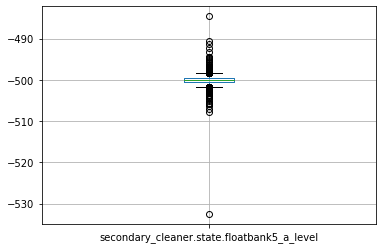

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_a_level: -498.40226777070393
Значений сверху отсечено: 66
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_a_level: -501.6012073598031
Значений снизу отсечено: 62
Проверка отсечения выбросов для secondary_cleaner.state.floatbank5_a_level:


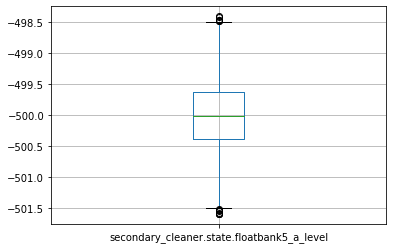

Ящик с усами для primary_cleaner.input.sulfate:


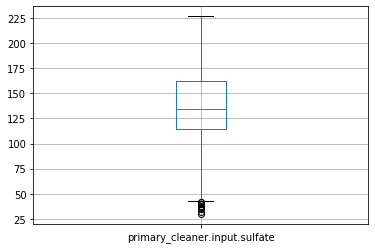

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.input.sulfate: 233.96168378296767
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.input.sulfate: 42.215353814137146
Значений снизу отсечено: 11
Проверка отсечения выбросов для primary_cleaner.input.sulfate:


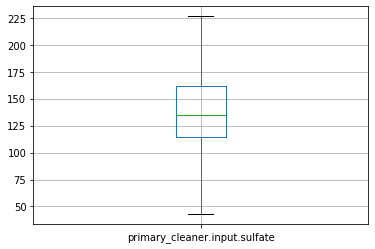

Ящик с усами для rougher.input.feed_size:


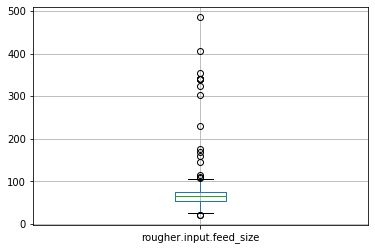

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_size: 107.41358527829844
Значений сверху отсечено: 18
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_size: 23.144201332723828
Значений снизу отсечено: 2
Проверка отсечения выбросов для rougher.input.feed_size:


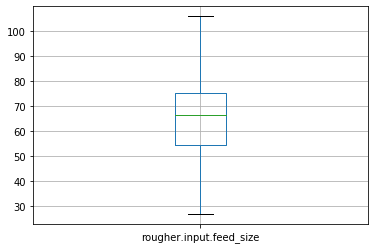

Ящик с усами для final.output.recovery:


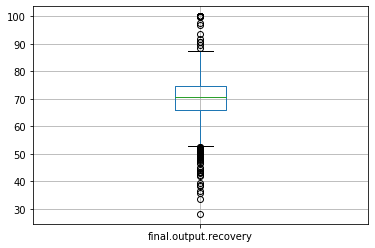

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра final.output.recovery: 87.70220273490216
Значений сверху отсечено: 18
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра final.output.recovery: 52.91579949423637
Значений снизу отсечено: 43
Проверка отсечения выбросов для final.output.recovery:


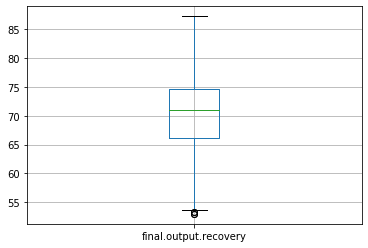

Ящик с усами для final.output.concentrate_au:


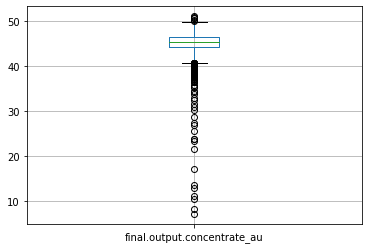

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра final.output.concentrate_au: 49.77200103154324
Значений сверху отсечено: 6
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра final.output.concentrate_au: 40.742703931943495
Значений снизу отсечено: 83
Проверка отсечения выбросов для final.output.concentrate_au:


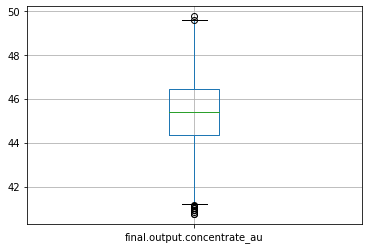

Ящик с усами для primary_cleaner.output.concentrate_au:


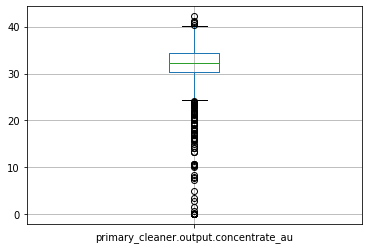

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра primary_cleaner.output.concentrate_au: 40.33441978514389
Значений сверху отсечено: 5
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра primary_cleaner.output.concentrate_au: 24.240166879753176
Значений снизу отсечено: 108
Проверка отсечения выбросов для primary_cleaner.output.concentrate_au:


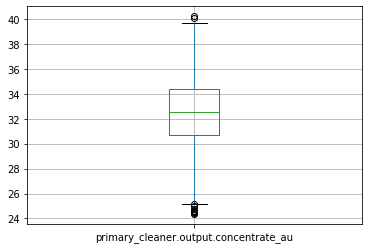

Ящик с усами для rougher.input.feed_sol:


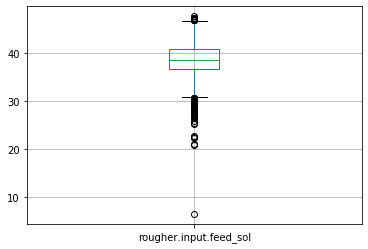

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_sol: 46.76323584159215
Значений сверху отсечено: 11
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_sol: 30.79296814176771
Значений снизу отсечено: 66
Проверка отсечения выбросов для rougher.input.feed_sol:


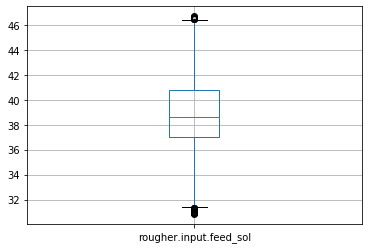

Ящик с усами для rougher.output.concentrate_sol:


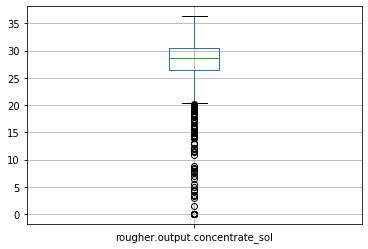

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.output.concentrate_sol: 36.656760159863374
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.output.concentrate_sol: 20.248063114219228
Значений снизу отсечено: 87
Проверка отсечения выбросов для rougher.output.concentrate_sol:


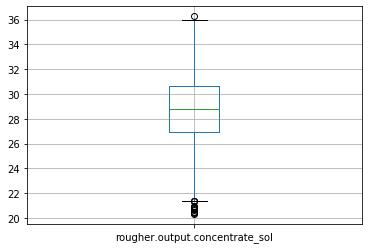

Ящик с усами для secondary_cleaner.state.floatbank2_b_air:


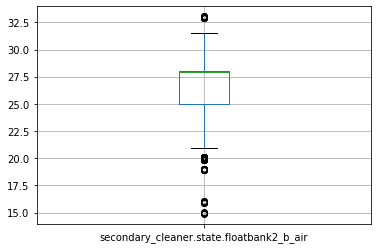

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_b_air: 32.56196885291124
Значений сверху отсечено: 42
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_b_air: 20.432588701194014
Значений снизу отсечено: 130
Проверка отсечения выбросов для secondary_cleaner.state.floatbank2_b_air:


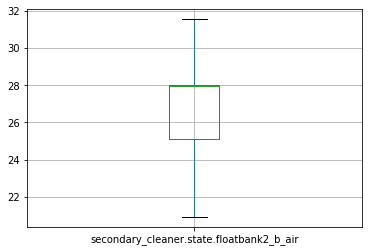

Ящик с усами для secondary_cleaner.state.floatbank2_a_air:


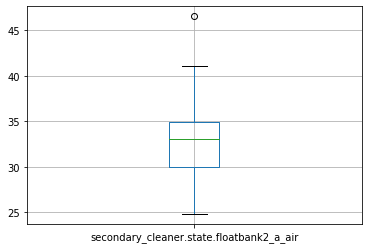

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_a_air: 42.38272895073632
Значений сверху отсечено: 1
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank2_a_air: 22.5711727283651
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank2_a_air:


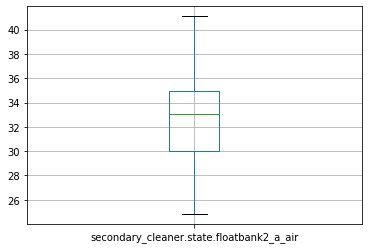

Ящик с усами для secondary_cleaner.state.floatbank3_a_air:


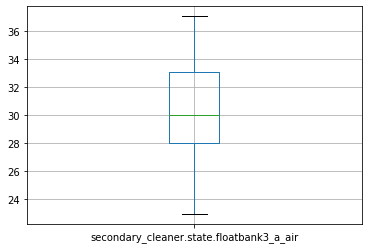

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_a_air: 40.738919907596056
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_a_air: 20.31513390964847
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank3_a_air:


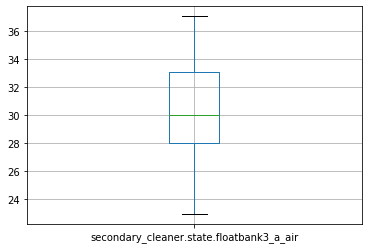

Ящик с усами для secondary_cleaner.state.floatbank5_a_air:


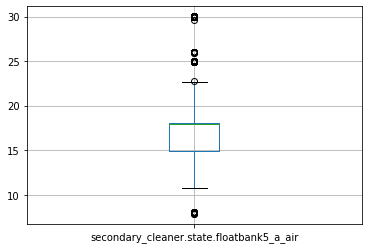

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_a_air: 22.688752086733285
Значений сверху отсечено: 204
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_a_air: 7.969289423452734
Значений снизу отсечено: 6
Проверка отсечения выбросов для secondary_cleaner.state.floatbank5_a_air:


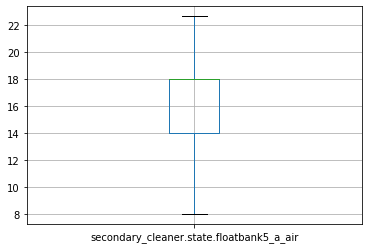

Ящик с усами для secondary_cleaner.state.floatbank6_a_air:


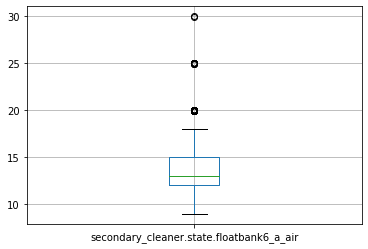

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank6_a_air: 19.47427724086012
Значений сверху отсечено: 84
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank6_a_air: 8.976209225395754
Значений снизу отсечено: 2
Проверка отсечения выбросов для secondary_cleaner.state.floatbank6_a_air:


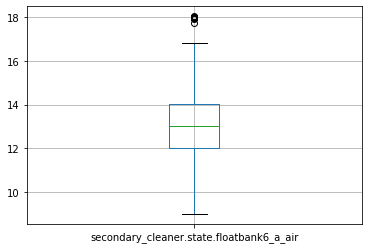

Ящик с усами для secondary_cleaner.state.floatbank4_a_air:


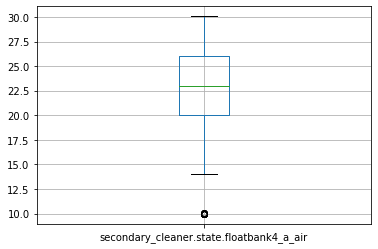

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_a_air: 35.02181974056244
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_a_air: 10.997964256266192
Значений снизу отсечено: 12
Проверка отсечения выбросов для secondary_cleaner.state.floatbank4_a_air:


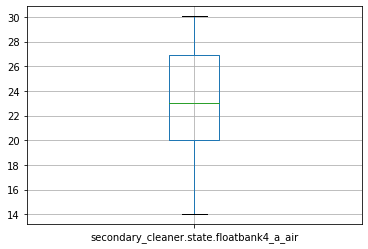

Ящик с усами для secondary_cleaner.state.floatbank5_b_air:


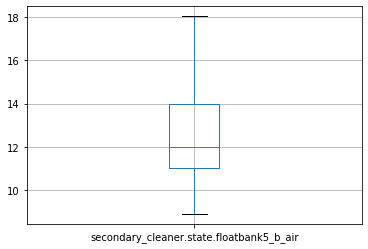

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_b_air: 18.411720358019096
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank5_b_air: 6.5913929723772515
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank5_b_air:


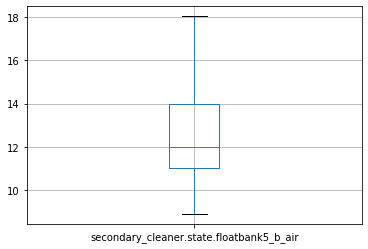

Ящик с усами для secondary_cleaner.state.floatbank3_b_air:


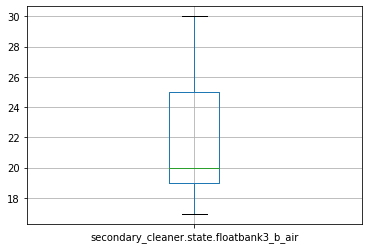

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_b_air: 33.90653655334186
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank3_b_air: 10.062983910781659
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank3_b_air:


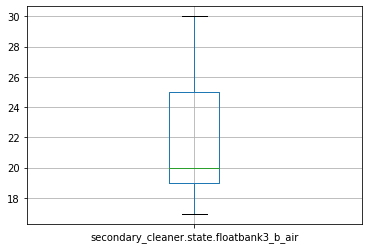

Ящик с усами для secondary_cleaner.state.floatbank4_b_air:


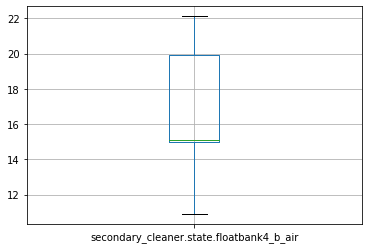

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_b_air: 27.40519897081738
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.state.floatbank4_b_air: 7.5235457843962905
Значений снизу отсечено: 0
Проверка отсечения выбросов для secondary_cleaner.state.floatbank4_b_air:


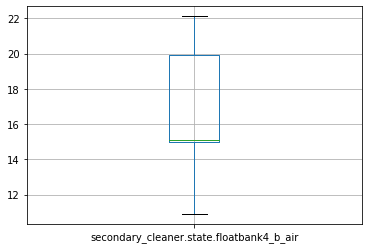

Ящик с усами для secondary_cleaner.output.tail_ag:


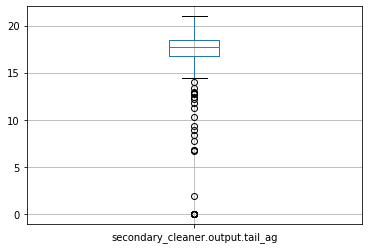

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.output.tail_ag: 21.04069455844266
Значений сверху отсечено: 0
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра secondary_cleaner.output.tail_ag: 14.268822428296422
Значений снизу отсечено: 34
Проверка отсечения выбросов для secondary_cleaner.output.tail_ag:


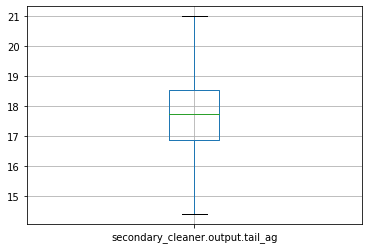

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.calculation.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-30 06:00:00,5.703921,11.156556,8.608833,42.847872,69.672157,11.335260,2.136291,19.422594,3.101553,183.004857,...,-497.091290,12.945545,-493.548159,13.936836,-501.589536,13.981294,-499.926608,15.956883,-500.327009,77.196230
2016-01-30 10:00:00,5.427243,11.503304,9.041869,43.765979,69.775052,11.547262,2.131402,18.604351,3.046262,188.686096,...,-498.572822,12.890314,-500.745609,13.990447,-500.776066,13.985071,-499.906914,16.000341,-499.418090,77.253362
2016-01-31 17:00:00,7.207911,8.343292,NaN,43.908149,70.110204,9.812226,0.117173,17.494613,1.855186,83.096684,...,-499.938113,13.008556,-501.474124,17.295667,-498.487250,15.263209,-499.985202,15.996922,-499.354822,76.127378
2016-02-05 20:00:00,6.602319,10.264526,6.544972,41.686498,74.934639,11.918786,1.819809,12.666784,2.574965,149.461881,...,-511.616735,15.975515,-498.526785,17.994234,-499.834882,16.050179,-499.279985,18.004229,-499.966332,86.676334
2016-02-05 21:00:00,6.253482,10.100309,7.078250,41.951803,73.816493,11.794366,1.690265,12.886808,2.520214,151.933482,...,-497.915932,16.026875,-511.336171,18.024845,-500.010427,15.996959,-500.069083,18.000447,-500.166215,84.729882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-31 00:59:59,3.451984,8.453317,10.118394,46.654345,79.518478,13.350836,2.166977,10.733847,2.336084,175.726691,...,-497.188830,17.038074,-500.103888,16.983305,-499.153678,12.990571,-500.339719,18.001329,-499.553702,88.232530
2018-07-31 07:59:59,3.402003,8.408830,9.950274,46.594131,77.963712,12.406455,2.223894,10.801904,2.154513,165.997336,...,-499.005998,17.027817,-499.968652,16.985448,-498.978132,13.032017,-499.954648,17.992367,-500.034775,89.300218
2018-07-31 08:59:59,3.558878,8.457297,10.015763,46.475235,74.565149,13.081696,2.354432,10.674332,2.135929,162.851656,...,-500.671331,17.061146,-499.881839,16.968750,-500.693550,12.982999,-499.703992,17.980928,-500.244332,88.579616


In [30]:
# spikes_drop(df_full, df_full.std().sort_values(ascending=False).head(30).index, distance=1.5)
spikes_drop(df_train, df_train.std().sort_values(ascending=False).head(30).index, distance=1.5)


In [31]:
df_full.shape

(22716, 90)

In [32]:
# Выкинем из обучающей выборки объекты, где суммарная концентрация равна нулю, поскольку они похожи на 
#заведомо ошибочные: 

for stage in ['rougher', 'primary_cleaner', 'final']:

    df_train[stage+'.output.concentrate_sum'] = sum(df_train[stage+'.output.concentrate_'+elem] 
                                                 for elem in ['ag', 'au', 'pb', 'sol'])
    df_train[df_train[stage+'.output.concentrate_sum'] == 0].dropna(inplace=True)

In [33]:
# Выкинем из df_train все те колонки, которые не содержатся в df_test:

df_train = df_train.drop(columns=(set(df_train.columns) - set(df_test.columns) - set(['final.output.recovery', 'rougher.output.recovery'])))


Ящик с усами для final.output.recovery:


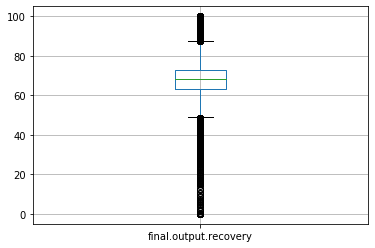

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра final.output.recovery: 87.4535001384469
Значений сверху отсечено: 620
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра final.output.recovery: 48.95222245854525
Значений снизу отсечено: 859
Проверка отсечения выбросов для final.output.recovery:


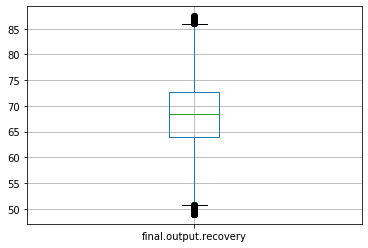

Ящик с усами для rougher.output.recovery:


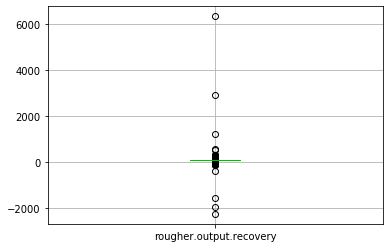

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.output.recovery: 103.31007073282477
Значений сверху отсечено: 107
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.output.recovery: 68.35953149091296
Значений снизу отсечено: 796
Проверка отсечения выбросов для rougher.output.recovery:


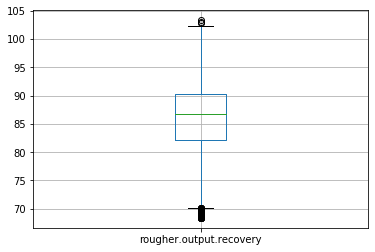

Ящик с усами для final.output.recovery:


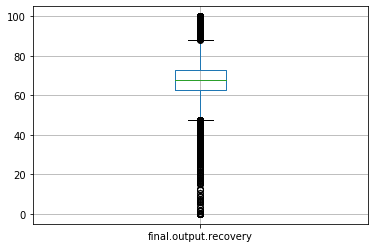

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра final.output.recovery: 87.97077811776711
Значений сверху отсечено: 552
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра final.output.recovery: 47.865701864257126
Значений снизу отсечено: 609
Проверка отсечения выбросов для final.output.recovery:


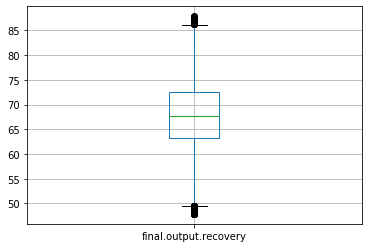

Ящик с усами для rougher.output.recovery:


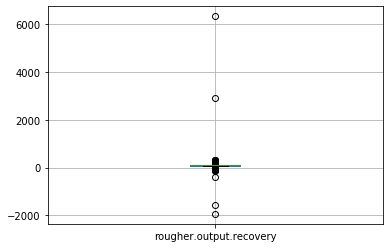

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.output.recovery: 105.25873600131648
Значений сверху отсечено: 79
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.output.recovery: 65.92436697968333
Значений снизу отсечено: 258
Проверка отсечения выбросов для rougher.output.recovery:


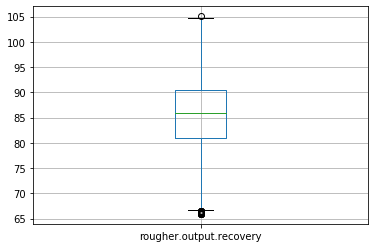

Ящик с усами для rougher.input.feed_size:


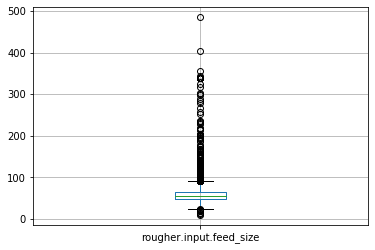

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_size: 91.795565427101
Значений сверху отсечено: 362
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_size: 25.003897772218455
Значений снизу отсечено: 16
Проверка отсечения выбросов для rougher.input.feed_size:


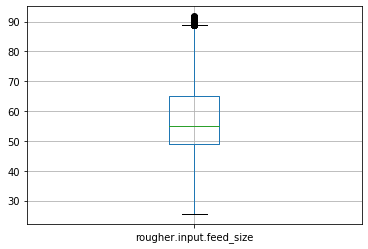

Ящик с усами для rougher.input.feed_size:


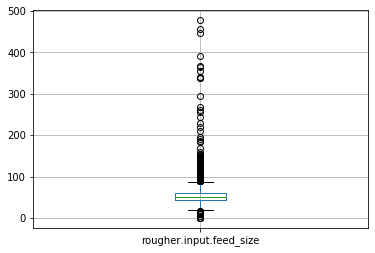

Отсекаем по верхнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_size: 88.25980869127523
Значений сверху отсечено: 247
Отсекаем по нижнему краю статистически значимой выборки (усов) для параметра rougher.input.feed_size: 19.39295604895232
Значений снизу отсечено: 16
Проверка отсечения выбросов для rougher.input.feed_size:


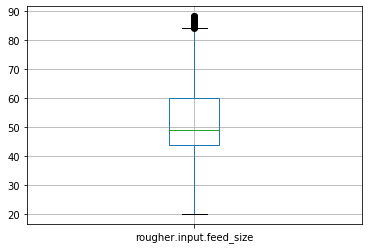

In [34]:
# Отсечем выбросы в целевых признаках, т.к. они мешают модели обучаться:

df_full = spikes_drop(df_full, ['final.output.recovery', 'rougher.output.recovery'], 1.5)
df_train = spikes_drop(df_train, ['final.output.recovery', 'rougher.output.recovery', 'rougher.input.feed_size'], 1.5)
df_test = spikes_drop(df_test, ['rougher.input.feed_size'], 1.5)

In [35]:
df_train.shape, df_test.shape

((12524, 54), (5571, 52))

Мы выкинули все объекты, удаление которых было оговорено на предыдущих этапах, а так же привели обучающую выборку к тому же виду, что и тестовая, поскольку это требуется по условию поставленной задачи. 
Так же мы удалили выбросы в целевых признаках и размерах гранул сырья. 

# 3. Модель

In [36]:
# Функция для контроля метрики sMAPE:
def sMAPE(target, prediction):

    """
    Принимает на вход два вектора - с ответами и с предказанными значениями. 
    На выход дает метрику sMAPE.
 
    
    """ 
    
    return 1/len(target) * np.sum((2 * np.abs(target - prediction) / (np.abs(target) + np.abs(prediction))) * 100)
# Функция для подсчёта итоговой метрики sMAPE:    
def sum_sMAPE(sMAPE_rougher, sMAPE_final):
    
    """
    Подсчитывает итоговую метрику sMAPE.
 
    
    """ 
    
    return sMAPE_rougher*0.25 + sMAPE_final*0.75
    


In [37]:
# Функция, осуществляющая обучение и проверку моделей при помощи кросс-валидации:

def models_trainer(model_class, params1, params2, features_train_1, features_train_2, target_train_1, target_train_2):

    """
    Функция, осуществляющая обучение и проверку моделей при помощи кросс-валидации: 
    model_class - тип модели машинного обучения
    params1/2 - словари с набором гиперпараметров для флотации/очистки соответственно
    features_train_1/2 -  обучающие выборки для флотации/чистовой очистки соответственно
    target_train_1/2 - выборки с целевыми признаками для флотации/чистовой очистки соответственно
    
    На выход функция выдаст обе модели и выведет промежуточные и итоговую оценки sMAPE
    
    """    
    model_1 = model_class(**params1)
    model_1.fit(features_train_1, target_train_1)
    score_1 = cross_val_score(model_1, features_train_1, target_train_1, cv=5, scoring=smape_scorer)
    #
    print('Средняя sMAPE для прогноза эффективности флотации: ', score_1.mean())
    #
    model_2 = model_class(**params2)
    model_2.fit(features_train_2, target_train_2)
    score_2 = cross_val_score(model_2, features_train_2, target_train_2, cv=5, scoring=smape_scorer )

    print('Средняя sMAPE для прогноза финальной эффективности : ', score_2.mean())
    print('Итоговая sMAPE:', sum_sMAPE(score_1.mean(), score_2.mean()))
    return model_1, model_2

In [38]:
# Функция получает на вход гиперпараметры и тип модели для флотации и финальной очистки, а так же тестовые выборки, выдаёт итоговое sMAPE:
def test_data_test(model_class1, model_class2, params1, params2, features_train_1, target_train_1,
                   features_train_2, target_train_2, features_test_1, features_test_2, 
                   target_test_1, target_test_2):
    
    """
    Функция оценки модели на тестовой выборке: 
    model_class1/2 - тип модели машинного обучения
    params1/2 - словарь с набором гиперпараметров
    features_train/test_1/2 -  выборка с признаками для обучающей/тестовой, флотации/чистовой очистки соответственно
    target_train/test_1/2 - целевые выборки для обучающей/тестовой, флотации/чистовой очистки соответственно
    На выход функция выдаст итоговую оценку sMAPE
    
    """
    
    model_1 = model_class1(**params1).fit(features_train_1, target_train_1)
    model_2 = model_class2(**params2).fit(features_train_2, target_train_2)
    prediction_1 = model_1.predict(features_test_1)
    prediction_2 = model_2.predict(features_test_2)

    return sum_sMAPE(sMAPE(target_test_1, prediction_1), sMAPE(target_test_2, prediction_2))

Напишем ряд функций, содержащих многократно используемый в ходе работы код для минимизации объема последнего.

#### 3.1. Напишите функцию для вычисления итоговой sMAPE.

##### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [40]:
# Перенесём таргеты в тестовую выборку:

df_test[['rougher.output.recovery', 'final.output.recovery']] = df_full.loc[df_test.index][['rougher.output.recovery', 'final.output.recovery']]

# Удалим оставшиеся на данном этапе пропуски:

df_train = df_train.replace([np.inf, -np.inf], np.nan)
df_test = df_test.replace([np.inf, -np.inf], np.nan)
df_train = df_train.dropna()
df_test = df_test.dropna()
# Отделим целевой признак от остальных:

target_train_rougher = df_train['rougher.output.recovery']
features_train_rougher = df_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)


target_train_final = df_train['final.output.recovery']
features_train_final = df_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)


target_test_rougher = df_test['rougher.output.recovery']
features_test_rougher = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

target_test_final = df_test['final.output.recovery']
features_test_final = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [38]:
df_train.shape

(11674, 54)

In [39]:
df_test.shape

(4777, 54)

Разобъем датафреймы на целевые и обучающие выборки. Для окончательной готовности выборок к работе требуется только удалить пропуски и оценить, насколько были урезаны изначальные выборки.

In [105]:
corr = abs(df_train.corrwith(df_train['rougher.output.recovery'])).sort_values(ascending=False).tail(15)
corr.index

Index(['primary_cleaner.state.floatbank8_d_air',
       'secondary_cleaner.state.floatbank6_a_level',
       'secondary_cleaner.state.floatbank4_a_level',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_level',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_level', 'rougher.input.feed_rate',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_level'],
      dtype='object')

In [106]:
corr = abs(df_train.corrwith(df_train['final.output.recovery'])).sort_values(ascending=False)
len(corr[corr<0.1])
corr.index

Index(['final.output.recovery', 'rougher.output.recovery',
       'primary_cleaner.input.sulfate', 'rougher.input.feed_ag',
       'rougher.input.feed_au', 'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_xanthate',
       'secondary_cleaner.state.floatbank4_a_air', 'rougher.input.feed_pb',
       'rougher.state.floatbank10_a_air', 'rougher.input.feed_sol',
       'rougher.state.floatbank10_c_air', 'rougher.input.feed_size',
       'rougher.state.floatbank10_d_air',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.input.xanthate', 'rougher.state.floatbank10_b_air',
       'secondary_cleaner.state.floatbank2_b_air',
       'primary_cleaner.input.depressant', 'rougher.state.floatbank10_e_air',
 

In [46]:
# Добавим собственную метрику оценки качества модели, она понадобится при кросс-валидации:
smape_scorer = make_scorer(sMAPE, greater_is_better=False)

#### Решающее дерево

In [41]:
# Подберем оптимальные гиперпараметры для решающего дерева, запишем их в лист dtr_best_params, где индекс - номер модели
# 1 - флотация, 2 - финальная очистка

model = DecisionTreeRegressor(random_state=123)
dtr_best_params = [0,0]
counter=0

for features_train, target_train in zip([features_train_rougher, features_train_final], 
                                        [target_train_rougher, target_train_final]):
    
    
    dtr_params = {'max_depth': range(1,36,11),
                  'min_samples_split': range(2, 9, 3),
                  'min_samples_leaf': range(1, 8, 3),
                  'splitter': ['best', 'random'],
                  'random_state':[123]
                  
                  
                 }

    dtr_cv = GridSearchCV(model, dtr_params, smape_scorer)
    dtr_cv.fit(features_train, target_train)
    
    dtr_best_params[counter] = dtr_cv.best_params_
    print(dtr_cv.best_params_)
    counter+=1
    

{'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 2, 'random_state': 123, 'splitter': 'random'}
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 123, 'splitter': 'random'}


In [42]:
model_tree1, model_tree2 = models_trainer(DecisionTreeRegressor, dtr_best_params[0], dtr_best_params[1], features_train_rougher, features_train_final, target_train_rougher, target_train_final)

Средняя sMAPE для прогноза эффективности флотации:  -6.286746388160428
Средняя sMAPE для прогноза финальной эффективности :  -7.10260021698048
Итоговая sMAPE: -6.898636759775466


#### Линейная регрессия

Масштабирование признаков не имеет смысла, т.к. разница в размерностях между значениями невелика.

In [43]:
# Подберем оптимальные гиперпараметры для линейной регрессии, запишем их в лист lir_best_params, где индекс - номер модели
# 1 - флотация, 2 - финальная очистка

model = LinearRegression()
lir_best_params = [0,0]
counter=0

for features_train, target_train in zip([features_train_rougher, features_train_final], 
                                        [target_train_rougher, target_train_final]):
    lir_params = {'fit_intercept': [True, False],
                  'normalize': [True, False]
                  

                  }

    lir_cv = GridSearchCV(model, lir_params, smape_scorer)
    lir_cv.fit(features_train, target_train)
    lir_best_params[counter]=lir_cv.best_params_
    print(lir_cv.best_params_)
    counter+=1

{'fit_intercept': False, 'normalize': True}
{'fit_intercept': True, 'normalize': False}


In [44]:
model_linear1, model_linear2 = models_trainer(LinearRegression, lir_best_params[0], lir_best_params[1], features_train_rougher, features_train_final, target_train_rougher, target_train_final)

Средняя sMAPE для прогноза эффективности флотации:  -6.375034423972678
Средняя sMAPE для прогноза финальной эффективности :  -8.033365842861084
Итоговая sMAPE: -7.618782988138983


#### Случайный лес

In [45]:
# Подберем оптимальные гиперпараметры для случайного леса, запишем их в лист rfr_best_params, где индекс - номер модели
# 1 - флотация, 2 - финальная очистка

model = RandomForestRegressor(random_state=123)

rfr_best_params = [0,0]
counter=0

for features_train, target_train in zip([features_train_rougher, features_train_final], 
                                        [target_train_rougher, target_train_final]):
    
    rfr_params = {'n_estimators': range(1,34,11), 
                  'max_depth': range(1,14,4),
                  'min_samples_split': range(2,9,3),
                  'min_samples_leaf': range(2,9,3),
                  'random_state':[123]
                  
                  
                  }

    rfr_cv = RandomizedSearchCV(model, rfr_params, scoring=smape_scorer)
    rfr_cv.fit(features_train, target_train)
    rfr_best_params[counter] = rfr_cv.best_params_
    print(rfr_cv.best_params_)
    counter+=1

{'random_state': 123, 'n_estimators': 23, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_depth': 9}
{'random_state': 123, 'n_estimators': 23, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 1}


In [46]:
model_forest1, model_forest2 = models_trainer(RandomForestRegressor, rfr_best_params[0], rfr_best_params[1], features_train_rougher, features_train_final, target_train_rougher, target_train_final)

Средняя sMAPE для прогноза эффективности флотации:  -5.739262714327038
Средняя sMAPE для прогноза финальной эффективности :  -7.138330869757998
Итоговая sMAPE: -6.788563830900258


#### К-ближайших соседей

In [47]:
# # Подберем оптимальные гиперпараметры для случайного леса, запишем их в лист knn_best_params, где индекс - номер модели
# # 1 - флотация, 2 - финальная очистка

# model = KNeighborsRegressor()

# knn_best_params = [0,0]
# counter=0

# for features_train, target_train in zip([features_train_rougher, features_train_final], 
#                                         [target_train_rougher, target_train_final]):
    
#     knn_params = {'n_neighbors': range(2,15,4), 
#                   'weights': ['uniform', 'distance'],
#                   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'leaf_size': range(2,35,11)
                  
                  
                  
#                   }

#     knn_cv = RandomizedSearchCV(model, knn_params, scoring=smape_scorer)
#     knn_cv.fit(features_train, target_train)
#     knn_best_params[counter] = knn_cv.best_params_
#     print(knn_cv.best_params_)
#     counter+=1

In [48]:
# model_knn1, model_knn2 = models_trainer(KNeighborsRegressor, knn_best_params[0], knn_best_params[1], features_train_rougher, features_train_final, target_train_rougher, target_train_final)

In [49]:
# Выбрав лучшую модель, заново обучим её на обучающей выборке и проверим на тестовой:
print('Суммарная метрика sMAPE на тестовой выборке: ', test_data_test(RandomForestRegressor, DecisionTreeRegressor, rfr_best_params[0], dtr_best_params[1], features_train_rougher, target_train_rougher, features_train_final, target_train_final, features_test_rougher, features_test_final, target_test_rougher, target_test_final))

Суммарная метрика sMAPE на тестовой выборке:  5.976870253508409


In [50]:

manual_predicton_rougher = pd.Series(data=[target_train_rougher.mean()]*len(target_test_rougher))
manual_predicton_final = pd.Series(data=[target_train_final.mean()]*len(target_test_final))
print('Суммарная метрика качества для константной модели:', sum_sMAPE(sMAPE(target_test_rougher.tolist(), manual_predicton_rougher), sMAPE(target_test_final.tolist(), manual_predicton_final)))

Суммарная метрика качества для константной модели: 6.442101208863299


In [51]:
print('Ошибка машинного прогноза ~ на {}% ниже ошибки константной модели.'.format(round(100- 100*6.028930495990778/6.442101208863299)))

Ошибка машинного прогноза ~ на 6% ниже ошибки константной модели.


### Вывод

В ходе выполнения проекта были проанализированы данные о переработке золотоносной руды. Данные были проверены на предмет пропусков и артефактов, а так же подготовлены к использованию модей машинного обучения. Были обучены модели, прогнозирующие эффективность обогащения на этапах флотации и финальной очистки, а так же проведена оценка качества этих моделей с исользованием метрики sMAPE, как по отдельности, так и вместе, при помощи интегральной оценки итоговой sMAPE. 



Наиболее эффективной при прогнозировании эффективности обогащения на этапе флотации оказалась модель "случайный лес", на этапе финальной очистки - "решающее дерево". На тестовой выборке была опробована комбинация из этих двух наиболее успешных моделей. Итоговая ошибка константной модели составила 6.44, для машинного предсказания  - 6.02, обеспечив, таким образом, снижение целевой метрики (т.е. повышение точности прогноза) на 6%. 